In [85]:
import pandas as pd
import numpy as np
#!pip install xgboosFFt
#from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, classification_report,\
    auc, roc_curve, roc_auc_score, average_precision_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from collections import defaultdict
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
import logging
import os

import warnings
warnings.filterwarnings("ignore")

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)

In [86]:
from keras import regularizers
from keras import backend as K
from keras.models import Sequential

from keras.layers import Embedding, Dense, Conv2D, MaxPooling2D, Reshape, Conv1D, MaxPooling1D,\
    Dropout, Activation, Input, Flatten, Concatenate, BatchNormalization, Lambda, LSTM, GRU, Bidirectional,\
    ZeroPadding2D
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras import regularizers
from keras.models import Model
from tensorflow.keras import optimizers
from keras import metrics
from keras import models
from keras import layers
from sklearn.utils import class_weight
import os
import random
from numpy.random import seed
import tensorflow
import pickle
from sklearn.utils import shuffle

from matplotlib import pyplot as plt
from scipy.stats import mannwhitneyu

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [87]:
import tensorflow as tf

In [65]:
# from google.colab import drive
# import sys, os

# drive.mount('/content/drive')

# cur_path = os.path.join('/content/drive/MyDrive/Colab_Notebooks','fraud')

# os.chdir(cur_path)
# print(os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab_Notebooks/fraud


## Prepare Data

In [66]:
WORD_CATS = ['WeakModal','Uncertainty', 'Negative', \
             'Compare', 'Positive', 'Litigious',\
           'StrongModal','Discrep','Achieve',  'Reward']

fin_cols = ['ch_rec', 'soft_asset', 'ch_cs', 'ch_roa', 'issue', 
            'asset_turnover', 'rg', 'depi', 'gmi',  'opm', 
            #'ch_inv',   #'aqi', #'sg', #'sgee'
           ]
target_col = "label"

In [67]:
def get_data(data, key_cols, word_cols, fin_cols, total_change_col, target_col):
    data = data[key_cols + fin_cols +  word_cols + [total_change_col] + [target_col]]
    data = data.sort_values(by = key_cols)
    return data

In [68]:
def set_seed():
    seed_value = 43
    os.environ['PYTHONASHSEED'] = str(seed_value)
    random.seed(seed_value)
    seed(seed_value)
    tensorflow.random.set_seed(seed_value)

# Functions

* if T = 1, call the model 'model_tcn'.

*  if T >=2, call model 'model_tcn_1'

*  For panel A, the 'baseline = False', the input shape is (#doc, #time-step, #word category (10), #change type (4))

*  For panel B and C, the 'baseline = True', the input shape is (#doc, #time-step, #word category (10))

### Random sampling models

In [69]:
def model_tcn(n1, n2, n3, T, perf, words, channel, baseline, filters=24, dropout=0):
    if baseline:
        model = None

        input_perf = Input(shape=(T, perf),
                           dtype='float32', name='input_perf')

        input_words = Input(shape=(T, words),  # ,channel \
                            dtype='float32', name='input_words')
        input_words_1 = Reshape(target_shape=(T, words, -1))(input_words)

        word_norm = BatchNormalization()(input_words_1)
        padding = ZeroPadding2D(padding=((0, 0), (words-1, 0)))(word_norm)

        print("shape after padding:", K.int_shape(padding))

        conv = Conv2D(filters=filters,
                      kernel_size=(1, words),
                      use_bias=False,
                      activation=None)(padding)  # Shape None x T x words x filters
        print("conv shape:", K.int_shape(conv))
        conv = BatchNormalization()(conv)
        conv = Activation("relu")(conv)

        pool = MaxPooling2D(pool_size=(1, words),
                            strides=(1, 1))(conv)  # None x T x filters
        pool = Reshape((T, filters))(pool)
        print("pool shape:", K.int_shape(pool))
        pool = Dropout(0.5)(pool)

        # Now concatenate
        perf_norm = BatchNormalization()(input_perf)
        all_input = Concatenate(axis=-1)([perf_norm, pool])

        dense = Dense(n3, activation='relu', name='dense')(all_input)
        drop = Dropout(0.5)(dense)

        preds = Dense(1, activation='sigmoid', name='output')(drop)
        model = Model(inputs=[input_perf, input_words], outputs=preds)
        model._name = "model_tcn_baseline"
        model.summary()

    else:
        model = None

        input_perf = Input(shape=(T, perf),
                           dtype='float32', name='input_perf')

        input_words = Input(shape=(T, words, channel),
                            dtype='float32', name='input_words')

        word_norm = BatchNormalization()(input_words)
        padding = ZeroPadding2D(padding=((0, 0), (words-1, 0)))(word_norm)

        print("shape after padding:", K.int_shape(padding))

        conv = Conv2D(filters=filters,
                      kernel_size=(1, words),
                      use_bias=False,
                      activation=None)(padding)  # Shape None x T x words x filters
        print("conv shape:", K.int_shape(conv))
        conv = BatchNormalization()(conv)
        conv = Activation("relu")(conv)

        pool = MaxPooling2D(pool_size=(1, words),
                            strides=(1, 1))(conv)  # None x T x filters

        pool = Reshape((T, filters))(pool)
        print("pool shape:", K.int_shape(pool))
        pool = Dropout(0.5)(pool)

        # Now concatenate
        perf_norm = BatchNormalization()(input_perf)
        all_input = Concatenate(axis=-1)([perf_norm, pool])
        all_rsp = Reshape((filters + input_perf.shape[2],))(all_input)

        dense = Dense(n3, activation='relu', name='dense0')(all_rsp)
        drop = Dropout(0.5)(dense)
        #dense = Dense(60, activation='relu', name='dense')(drop)
        preds = Dense(1, activation='sigmoid', name='output')(dense)
        model = Model(inputs=[input_perf, input_words], outputs=preds)
        model._name = "model_tcn"
        model.summary()

    return model

In [70]:
# for window > 1
def model_tcn_1(n1, n2, n3, T, perf, words, channel, baseline, filters=24, dropout=0):
    if baseline:
        model = None

        input_perf = Input(shape=(T, perf),
                           dtype='float32', name='input_perf')

        input_words = Input(shape=(T, words),  # ,channel
                            dtype='float32', name='input_words')
        input_words_1 = Reshape(target_shape=(T, words, -1))(input_words)

        word_norm = BatchNormalization()(input_words_1)
        padding = ZeroPadding2D(padding=((0, 0), (words-1, 0)))(word_norm)

        print("shape after padding:", K.int_shape(padding))

        conv = Conv2D(filters=filters,
                      kernel_size=(1, words),
                      use_bias=False,
                      activation=None)(padding)  # Shape None x T x words x filters
        print("conv shape:", K.int_shape(conv))
        conv = BatchNormalization()(conv)
        conv = Activation("relu")(conv)

        pool = MaxPooling2D(pool_size=(1, words),
                            strides=(1, 1))(conv)  # None x T x filters
        pool = Reshape((T, filters))(pool)
        print("pool shape:", K.int_shape(pool))

        # Now concatenate
        perf_norm = BatchNormalization()(input_perf)
        all_input = Concatenate(axis=-1)([perf_norm, pool])

        LSTM_w_1 = Bidirectional(LSTM(n1, dropout=0.3, recurrent_dropout=0.3,
                                      name='layer_lstm_1', return_sequences=False))(all_input)

        dense = Dense(n3, activation='relu', name='dense')(LSTM_w_1)
        drop = Dropout(0.5)(dense)

        preds = Dense(1, activation='sigmoid', name='output')(drop)
        model = Model(inputs=[input_perf, input_words], outputs=preds)
        model._name = "model_tcn_1_baseline"
        model.summary()

    else:

        model = None

        input_perf = Input(shape=(T, perf),
                           dtype='float32', name='input_perf')

        input_words = Input(shape=(T, words, channel),
                            dtype='float32', name='input_words')

        word_norm = BatchNormalization()(input_words)
        padding = ZeroPadding2D(padding=((0, 0), (words-1, 0)))(word_norm)

        print("shape after padding:", K.int_shape(padding))

        conv = Conv2D(filters=filters,
                      kernel_size=(1, words),
                      use_bias=False,
                      activation=None)(padding)  # Shape None x T x words x filters
        print("conv shape:", K.int_shape(conv))
        conv = BatchNormalization()(conv)
        conv = Activation("relu")(conv)
        pool = MaxPooling2D(pool_size=(1, words),
                            strides=(1, 1))(conv)  # None x T x filters
        pool = Reshape((T, filters))(pool)
        print("pool shape:", K.int_shape(pool))

        # Now concatenate
        perf_norm = BatchNormalization()(input_perf)
        all_input = Concatenate(axis=-1)([perf_norm, pool])

        LSTM_w_1 = Bidirectional(LSTM(n1, dropout=0.3, recurrent_dropout=0.3,
                                      name='layer_lstm_1',
                                      return_sequences=False,
                                      ))(all_input)
        # LSTM_w_2 = LSTM(n2, dropout= 0.3, recurrent_dropout = 0.3,
        #               name = 'layer_lstm_2', return_sequences=False)(LSTM_w_1)

        drop = Dropout(0.5)(LSTM_w_1)
        #dense = Dense(n3, activation='relu', name='dense')(drop)

        preds = Dense(1, activation='sigmoid', name='output')(drop)
        model = Model(inputs=[input_perf, input_words], outputs=preds)
        model._name = "model_tcn_1"
        model.summary()

    return model

### Model for train all data

#### Full Model

In [97]:
def model_tcn_lstm_no_sampling(T, perf, words, channel, filters=24, lstm_units = 48, dense_units = 48, dropout_rate=0):
    

  input_perf = Input(shape=(T, perf),
                           dtype='float32', name='input_perf')

  input_words = Input(shape=(T, words, channel),
                            dtype='float32', name='input_words')

  word_norm = BatchNormalization()(input_words)
  padding = ZeroPadding2D(padding=((0, 0), (words-1, 0)))(word_norm)

  #print("shape after padding:", K.int_shape(padding))

  conv = Conv2D(filters=filters,
                      kernel_size=(1, words),
                      use_bias=False,
                      activation=None)(padding)  # Shape None x T x words x filters
  print("conv shape:", K.int_shape(conv))
  conv = BatchNormalization()(conv)
  conv = Activation("relu")(conv)
  pool = MaxPooling2D(pool_size=(1, words),
                            strides=(1, 1))(conv)  # None x T x filters
  
  # if time window is 1, just flatten all layers to a dense layer                         
  pool = Reshape((T, filters))(pool)
  
  # Now concatenate
  perf_norm = BatchNormalization()(input_perf)
  all_input = Concatenate(axis=-1)([perf_norm, pool])

  output = Bidirectional(LSTM(lstm_units, dropout=0.3, recurrent_dropout=0.3,
                                      name='layer_lstm_1',
                                      return_sequences=True,
                                      ))(all_input)
  output = LSTM(lstm_units, dropout= 0.3, recurrent_dropout = 0.3,
                 name = 'layer_lstm_2', return_sequences=False)(output)
  
  drop = Dropout(dropout_rate)(output)
   
  preds = Dense(1, activation='sigmoid', name='output')(drop)
  model = Model(inputs=[input_perf, input_words], outputs=preds)
  model._name = "model_tcn"
  model.summary()

  return model

#### LSTM only

In [98]:
def model_lstm_only_no_sampling(T, perf,  lstm_units = 48, bidirectional = True,
                                dense_units = 48, dropout_rate=0):
    

  input_perf = Input(shape=(T, perf),
                           dtype='float32', name='input_perf')

  
  perf_norm = BatchNormalization()(input_perf)

  if bidirectional:
     output = Bidirectional(LSTM(lstm_units, dropout=0.3, recurrent_dropout=0.3,
                                      name='layer_lstm_1',
                                      return_sequences=True,
                                      ))(perf_norm)
  else:
     output = LSTM(lstm_units, dropout=0.3, recurrent_dropout=0.3,
                                      name='layer_lstm_1',
                                      return_sequences=True,
                                      )(perf_norm)
                                  
  output = LSTM(lstm_units, dropout= 0.3, recurrent_dropout = 0.3,
                 name = 'layer_lstm_2', return_sequences=False)(output)
  
  drop = Dropout(dropout_rate)(output)
   
  preds = Dense(1, activation='sigmoid', name='output')(drop)
  model = Model(inputs= input_perf, outputs=preds)
  model._name = "model_lstm_only"
  model.summary()

  return model

### Model for train sampled data

####  Full model

In [99]:
def model_tcn_lstm(T, perf, words, channel, filters=24, lstm_units = 48, dense_units = 48, dropout_rate=0):
    

  input_perf = Input(shape=(T, perf),
                           dtype='float32', name='input_perf')

  input_words = Input(shape=(T, words, channel),
                            dtype='float32', name='input_words')

  word_norm = BatchNormalization()(input_words)
  padding = ZeroPadding2D(padding=((0, 0), (words-1, 0)))(word_norm)

  #print("shape after padding:", K.int_shape(padding))

  conv = Conv2D(filters=filters,
                      kernel_size=(1, words),
                      use_bias=False,
                      activation=None)(padding)  # Shape None x T x words x filters
  print("conv shape:", K.int_shape(conv))
  conv = BatchNormalization()(conv)
  conv = Activation("relu")(conv)
  pool = MaxPooling2D(pool_size=(1, words),
                            strides=(1, 1))(conv)  # None x T x filters
  
  # if time window is 1, just flatten all layers to a dense layer                         
  pool = Reshape((T, filters))(pool)
  
  # Now concatenate
  perf_norm = BatchNormalization()(input_perf)
  all_input = Concatenate(axis=-1)([perf_norm, pool])

  output = Bidirectional(LSTM(lstm_units, dropout=0.3, recurrent_dropout=0.3,
                                      name='layer_lstm_1',
                                      return_sequences=False,
                                      ))(all_input)
        # LSTM_w_2 = LSTM(n2, dropout= 0.3, recurrent_dropout = 0.3,
        #               name = 'layer_lstm_2', return_sequences=False)(LSTM_w_1)
  
  drop = Dropout(dropout_rate)(output)
   
  preds = Dense(1, activation='sigmoid', name='output')(drop)
  model = Model(inputs=[input_perf, input_words], outputs=preds)
  model._name = "model_tcn"
  #model.summary()

  return model

#### LSTM only

In [100]:
def model_lstm_only(T, perf,  lstm_units = 48, bidirectional = True,
                    dense_units = 48, dropout_rate=0):
    

  input_perf = Input(shape=(T, perf),
                           dtype='float32', name='input_perf')

  
  perf_norm = BatchNormalization()(input_perf)

  if bidirectional:

    output = Bidirectional(LSTM(lstm_units, dropout=0.3, recurrent_dropout=0.3,
                                      name='layer_lstm_1',
                                      return_sequences=False,
                                      ))(perf_norm)
  else:
    output = LSTM(lstm_units, dropout=0.3, recurrent_dropout=0.3,
                                      name='layer_lstm_1',
                                      return_sequences=False,
                                      )(perf_norm)
        # LSTM_w_2 = LSTM(n2, dropout= 0.3, recurrent_dropout = 0.3,
        #               name = 'layer_lstm_2', return_sequences=False)(LSTM_w_1)
  
  drop = Dropout(dropout_rate)(output)
   
  preds = Dense(1, activation='sigmoid', name='output')(drop)
  model = Model(inputs= input_perf, outputs=preds)
  model._name = "model_lstm_only"
  #model.summary()

  return model

### Training functions

#### Transform data

In [101]:
# overall_change includes in perf_cols

def shift_data(data, step, perf_cols, words_cols, label, metrics_per_word = 4):

        A = []

        cols = perf_cols + words_cols
        A.append(data[cols].values)

        #print(cols)

        for t in range(1, step):
            d = data.groupby("cik")[cols].shift(t)
            A.append(d.values)
        A = A[::-1]
        A = np.concatenate(A, axis=1)  # flatten shifted columns
        A = np.concatenate([data[label].values[:, None], A],
                           axis=1)  # add target


        A = A[~np.isnan(A).any(axis=1)]  # drop nan

        Y = A[:, 0]  # get target
        # A = np.reshape(A[:,1:], (len(A), step, len(cols))) # reshape

        A = np.reshape(
            A[:, 1:], (len(A), step, len(perf_cols) + len(words_cols)))

        A_perf = A[:, :, 0:len(perf_cols)]
        # CNN_LSTM must be None x T x words x 4
        A_words = A[:, :, len(perf_cols):]
        # convert the shape to [[_p,_new][_dis,_n]]
        A_words = A_words.reshape(
            (len(A), step, int(len(words_cols)/metrics_per_word), metrics_per_word), order='C')

        print('in shift function:', A_perf.shape,
              A_words.shape, Y.sum(), label)
        
        return A_perf, A_words, Y

In [102]:
# overall_change includes in perf_cols

# Some CIKs have missed some years. A sequence of 3 years may not always be continus
# It could be (2000, 2001), (2002, 2003), (2003, 2004)

def shift_data_with_cutoff(data, step, perf_cols, words_cols, label, 
                           cutoff= [2000,2000], metrics_per_word = 4):
        
        A = []
        cutoff_index = data[(data.y2>=cutoff[0]) & (data.y2<cutoff[1])].index.tolist()
        print('data shape: ', data.shape)
        print('cutoff index: ', len(cutoff_index))
        
        cols = perf_cols + words_cols
        #print(cols, label)
        A.append(data[cols].values)

        #print(cols)

        for t in range(1, step):
            d = data.groupby("cik")[cols].shift(t)
            A.append(d.values)
        A = A[::-1]
        A = np.concatenate(A, axis=1)  # flatten shifted columns
        A = np.concatenate([data[label].values[:, None], A],
                           axis=1)  # add target

        print('init A shape: ', A.shape)
        
        
        # only choose set with selected indexes
        A = A[cutoff_index]
        #print('A shape after cutoff: ', A.shape)
    

        A = A[~np.isnan(A).any(axis=1)]  # drop nan
        print('A shape after remove null value: ', A.shape)

        Y = A[:, 0]  # get target
        # A = np.reshape(A[:,1:], (len(A), step, len(cols))) # reshape

        A = np.reshape(
            A[:, 1:], (len(A), step, len(perf_cols) + len(words_cols)))

        A_perf = A[:, :, 0:len(perf_cols)]
        # CNN_LSTM must be None x T x words x 4
        A_words = A[:, :, len(perf_cols):]
        # convert the shape to [[_p,_new][_dis,_n]]
        A_words = A_words.reshape(
            (len(A), step, int(len(words_cols)/metrics_per_word), metrics_per_word), order='C')

        print('in shift function:', A_perf.shape,
              A_words.shape, Y.sum(), label)
        
        return A_perf, A_words, Y

In [103]:
def shift_data_wo_words(data, step, perf_cols, label):

        A = []

        cols = perf_cols 
        A.append(data[cols].values)

        #print(cols)

        for t in range(1, step):
            d = data.groupby("cik")[cols].shift(t)
            A.append(d.values)
        A = A[::-1]
        A = np.concatenate(A, axis=1)  # flatten shifted columns
        A = np.concatenate([data[label].values[:, None], A],
                           axis=1)  # add target


        A = A[~np.isnan(A).any(axis=1)]  # drop nan

        Y = A[:, 0]  # get target
        # A = np.reshape(A[:,1:], (len(A), step, len(cols))) # reshape

        A_perf = np.reshape(A[:, 1:], (len(A), step, len(perf_cols)))
        
        print('in shift function:', A_perf.shape, Y.sum(), label)
        
        return A_perf,  Y

#### Fit Model

In [104]:
def fit_model(model, x_train, y_train, x_val, y_val, x_test = None, y_test = None, \
              model_name='model',class_weight = None, early_stopping = False, \
              epoch=100, verbose=2, lr=0.0005):

    history = None
    result = None

    model_df = model
    #print('in fit, val_y: ', sum(y_val),  'train_y', sum(y_train))

    opt = optimizers.RMSprop(lr=lr)
    model_df.compile(optimizer=opt,
                     loss='binary_crossentropy',
                     metrics=['accuracy', metrics.AUC(name='auc'), metrics.AUC(name='prc', curve ='PR'),
                              metrics.Precision(name='prec'), metrics.Recall(name='recall')])

    if early_stopping: 

      earlyStopping = EarlyStopping( monitor="val_auc", mode="max", patience = 5)

      history = model_df.fit(x_train,
                           y_train,
                           epochs=epoch,
                           batch_size=256,
                           verbose=verbose,
                           callbacks=[earlyStopping], #checkpoint
                           class_weight = class_weight,
                           validation_data=(x_val, y_val))  # , val_sample_weights
    else:
      history = model_df.fit(x_train,
                           y_train,
                           epochs=epoch,
                           batch_size=256,
                           verbose=verbose,
                           # callbacks=[auc_eval],\
                           # callbacks=[auc_eval, earlyStopping, checkpoint], #checkpoint
                           class_weight = class_weight, 
                           validation_data=(x_val, y_val))  # , val_sample_weights
    #model_df.save(model_name+".h5")

    return history

#### Cross Validation; No Sampling

##### Full model

In [105]:
def cross_validate(data, label, perf_cols, words_cols,  w, num_epoch, cv =4, name = "model",\
                         num_filter = 48, metrics_per_word=4, lstm_units = 64, dense_units = 64, \
                         class_weight = None, lr=0.0005, verbose = 1):

    # save all history for later analysis
    hists = {}
    hists[0] = {}

    c = 0
    data = data.sort_values(by=['cik', 'y2'])
    X_perf, X_word, Y = shift_data(data.astype('float'), w,
                                   perf_cols,
                                   words_cols,
                                   label,
                                   metrics_per_word = metrics_per_word)

    kf = StratifiedKFold(n_splits=cv, shuffle=True)

    # kf.split only returns current index
    for train_index, test_index in kf.split(range(len(X_perf)), Y):

        c += 1

        train_perf_data = X_perf[train_index]
        train_word_data = X_word[train_index]
        train_label = Y[train_index]

        test_perf_x = X_perf[test_index]
        test_word_x = X_word[test_index]
        test_label = Y[test_index]

        x_train = [train_perf_data, train_word_data]
        x_test = [test_perf_x, test_word_x]

        print(f"kfold: {c}, \
                train size: {len(train_index)}, \
                test size: {len(test_index)}, \
                train Y: {train_label.sum()},\
                test Y: {test_label.sum()}")

        model = model_tcn_lstm_no_sampling(T = train_perf_data.shape[1],        
              perf = train_perf_data.shape[2],
              words = train_word_data.shape[2],
              channel = train_word_data.shape[3],
              filters=num_filter,
              lstm_units = lstm_units, 
              dense_units = dense_units, 
              dropout_rate= 0.5
              )

        mod_res = fit_model(model, 
                      x_train =x_train, 
                      y_train = train_label, 
                      x_val = x_test, 
                      y_val = test_label,
                      model_name = name, 
                      class_weight = class_weight,
                      epoch = num_epoch, 
                      verbose= verbose, 
                      early_stopping = False,
                      lr=lr)  

        hists[0][c] = mod_res
            
    return hists

##### LSTM only

In [106]:
def cross_validate_lstm_only(data, label, perf_cols, num_epoch, cv =4, name = "model",\
                         lstm_units = 64, dense_units = 64, bidirectional = True,\
                         class_weight = None, lr=0.0005, verbose = 1):

    # save all history for later analysis
    hists = {0: {}}

    c = 0
    data = data.sort_values(by=['cik', 'y2'])
    X_perf,  Y = shift_data_wo_words(data.astype('float'), w,
                                   perf_cols,                                  
                                   label)

    kf = StratifiedKFold(n_splits=cv, shuffle=True)

    # kf.split only returns current index
    for train_index, test_index in kf.split(range(len(X_perf)), Y):

        c += 1

        train_perf_data = X_perf[train_index]
        train_label = Y[train_index]

        test_perf_x = X_perf[test_index]
        test_label = Y[test_index]

        print(f"kfold: {c}, \
                train size: {len(train_index)}, \
                test size: {len(test_index)}, \
                train Y: {train_label.sum()},\
                test Y: {test_label.sum()}")
    

        x_train = train_perf_data
        x_test = test_perf_x

        model = model_lstm_only_no_sampling(T = train_perf_data.shape[1],        
              perf = train_perf_data.shape[2], bidirectional = bidirectional,
              lstm_units = lstm_units, 
              dense_units = dense_units, 
              dropout_rate= 0.5
              )
        
        #print(model.summary())

        mod_res = fit_model(model, 
                      x_train =x_train, 
                      y_train = train_label, 
                      x_val = x_test, 
                      y_val = test_label,
                      model_name = name, 
                      class_weight = class_weight,
                      epoch = num_epoch, 
                      verbose= verbose, 
                      early_stopping = False,
                      lr=lr)  

        hists[0][c] = mod_res
            
    return hists

#### Sampling

##### Full Model

In [107]:
def repeated_sampling_cv(data, label, perf_cols, words_cols,  w, num_epoch, cv =4, name = "model",\
                         rounds = 20, num_filter = 48, metrics_per_word=4, lstm_units = 64, dense_units = 64, \
                         class_weight = None, lr=0.0005, verbose = 1):

    # save all history for later analysis
    hists = {}

    c = 0
    data = data.sort_values(by=['cik', 'y2'])
    X_perf, X_word, Y = shift_data(data.astype('float'), w,
                                   perf_cols,
                                   words_cols,
                                   label,
                                   metrics_per_word = metrics_per_word)

    pos_index = np.where(Y == 1)[0]
    neg_index = np.where(Y == 0)[0]

    sampled_folds = np.random.choice(
        neg_index, size=[rounds, len(pos_index)], replace=True)

    for round, neg_sampled_index in enumerate(sampled_folds):
        batch_indexes = np.concatenate([pos_index, neg_sampled_index])
        batch_Y = np.array([1] * len(pos_index) + [0] * len(neg_sampled_index))

        print("\n===========round: {0}, X: {1}, Y: {2} ======".format(
            round, batch_indexes.shape, batch_Y.shape))
        # cross validation for each round
        c = 0

        hists[round] = {}

        kf = StratifiedKFold(n_splits=cv, shuffle=True)

        # kf.split only returns current index
        for train_index, test_index in kf.split(batch_indexes, batch_Y):

            # indexes are split based batch_indexes
            train_index = batch_indexes[train_index]
            test_index = batch_indexes[test_index]

            print("round: ", round, 'kfold: ', c, "train size: ", len(
                train_index), "test size: ", len(test_index))
            c += 1

            train_perf_data = X_perf[train_index]
            train_word_data = X_word[train_index]
            train_label = Y[train_index]

            test_perf_x = X_perf[test_index]
            test_word_x = X_word[test_index]
            test_label = Y[test_index]

            x_train = [train_perf_data, train_word_data]
            x_test = [test_perf_x, test_word_x]

            model = model_tcn_lstm(T = train_perf_data.shape[1],        
                  perf = train_perf_data.shape[2],
                  words = train_word_data.shape[2],
                  channel = train_word_data.shape[3],
                  filters=num_filter,
                  lstm_units = lstm_units, 
                  dense_units = dense_units, 
                  dropout_rate= 0.5
                  )

            mod_res = fit_model(model, 
                          x_train =x_train, 
                          y_train = train_label, 
                          x_val = x_test, 
                          y_val = test_label,
                          model_name = name, 
                          class_weight = class_weight,
                          epoch = num_epoch, 
                          verbose= verbose, 
                          early_stopping = False,
                          lr=lr)  


            hists[round][c] = mod_res
            
    return hists

##### LSTM only

In [108]:
def repeated_sampling_cv_lstm_only(data, label, perf_cols, num_epoch, cv =4, name = "model",\
                         rounds = 20, lstm_units = 64, dense_units = 64, bidirectional = True, \
                         class_weight = None, lr=0.0005, verbose = 1):

    # save all history for later analysis
    hists = {}

    c = 0
    data = data.sort_values(by=['cik', 'y2'])
    X_perf,  Y = shift_data_wo_words(data.astype('float'), w,
                                   perf_cols,                                  
                                   label)

    pos_index = np.where(Y == 1)[0]
    neg_index = np.where(Y == 0)[0]

    sampled_folds = np.random.choice(
        neg_index, size=[rounds, len(pos_index)], replace=True)

    for round, neg_sampled_index in enumerate(sampled_folds):
        batch_indexes = np.concatenate([pos_index, neg_sampled_index])
        batch_Y = np.array([1] * len(pos_index) + [0] * len(neg_sampled_index))

        print("\n===========round: {0}, X: {1}, Y: {2} ======".format(
            round, batch_indexes.shape, batch_Y.shape))
        # cross validation for each round
        c = 0

        hists[round] = {}

        kf = StratifiedKFold(n_splits=cv, shuffle=True)

        # kf.split only returns current index
        for train_index, test_index in kf.split(batch_indexes, batch_Y):

            # indexes are split based batch_indexes
            train_index = batch_indexes[train_index]
            test_index = batch_indexes[test_index]

            print("round: ", round, 'kfold: ', c, "train size: ", len(
                train_index), "test size: ", len(test_index))
            c += 1

            train_perf_data = X_perf[train_index]
            train_label = Y[train_index]

            test_perf_x = X_perf[test_index]
            test_label = Y[test_index]

            x_train = train_perf_data
            x_test = test_perf_x

            model = model_lstm_only(T = train_perf_data.shape[1],        
                  perf = train_perf_data.shape[2], bidirectional = bidirectional,
                  lstm_units = lstm_units, 
                  dense_units = dense_units, 
                  dropout_rate= 0.5
                  )
            
            #print(model.summary())

            mod_res = fit_model(model, 
                          x_train =x_train, 
                          y_train = train_label, 
                          x_val = x_test, 
                          y_val = test_label,
                          model_name = name, 
                          class_weight = class_weight,
                          epoch = num_epoch, 
                          verbose= verbose, 
                          early_stopping = False,
                          lr=lr)  


            hists[round][c] = mod_res
            
    return hists

#### Random Sampling + Out of Sample

In [109]:
def sampling_with_test(data, label, perf_cols, words_cols, 
                       name, w, num_epoch, cutoff=[2000, 2001], 
                       rounds = 20, num_filter = 48, 
                       metrics_per_word=4, lstm_units = 64, dense_units = 64, \
                  class_weight = None, lr=0.0005, verbose = 1):

    
                   
    # save all history for later analysis
    hists = {}
    
    start_year = cutoff[0]
    end_year = cutoff[1]

    
    # Test dataset
    X_test_perf, X_test_word, Y_test = shift_data_with_cutoff(data.astype('float'), w,
                                   perf_cols,
                                   words_cols,
                                   target_col,
                                   cutoff = [start_year, end_year],                         
                                   metrics_per_word = metrics_per_word)
    
    print("\n===========Test set: {0}, {1}, positives: {2} ======".format(
            X_test_perf.shape, X_test_word.shape, Y_test.sum()))
    
    test_pos_index = np.where(Y_test == 1)[0]
    test_neg_index = np.where(Y_test == 0)[0]
    
    sampled_test_index = np.random.choice(
        test_neg_index, size=[rounds, 10*len(test_pos_index)], replace=True)
    
    # Train dataset
    data_train = data[data.y2 < start_year]
    X_perf, X_word, Y = shift_data(data_train.astype('float'), w,
                                   perf_cols,
                                   words_cols,
                                   label,
                                   metrics_per_word = metrics_per_word)
    print("\n===========Train: {0}, {1}, {2} ======".format(
            X_perf.shape, X_word.shape, Y.sum()))

    pos_index = np.where(Y == 1)[0]
    neg_index = np.where(Y == 0)[0]

    sampled_folds = np.random.choice(
        neg_index, size=[rounds, len(pos_index)], replace=True)
    
    for round, neg_sampled_index in enumerate(sampled_folds):

        batch_indexes = np.concatenate([pos_index, neg_sampled_index])
        batch_indexes = shuffle(batch_indexes)

        print("\n===========round: {0}, train: X: {1}, Y: {2} ======".format(
            round, batch_indexes.shape, Y[batch_indexes].sum()))
        
        train_perf_data = X_perf[batch_indexes]
        train_word_data = X_word[batch_indexes]
        train_label = Y[batch_indexes]
        
        print("Train set:", train_perf_data.shape,train_word_data.shape)

        x_train = [train_perf_data, train_word_data]
        
        # test
        test_batch_indexes = np.concatenate([np.repeat(test_pos_index,10), sampled_test_index[round]])
        test_perf_data = X_test_perf[test_batch_indexes]
        test_word_data = X_test_word[test_batch_indexes]
        test_label = Y_test[test_batch_indexes]
        #print(test_label)
        x_val = [test_perf_data, test_word_data]
        print("Test set:", test_perf_data.shape,test_word_data.shape)
        
        print("\n===========round: {0}, test: X: {1}, Y: {2} ======".format(
            round, test_batch_indexes.shape, test_label.sum()))

        model = model_tcn_lstm(T = train_perf_data.shape[1],        
                  perf = train_perf_data.shape[2],
                  words = train_word_data.shape[2],
                  channel = train_word_data.shape[3],
                  filters=num_filter,
                  lstm_units = lstm_units, 
                  dense_units = dense_units, 
                  dropout_rate= 0.5
                  )
        
        #print(model.summary())

        mod_res = fit_model(model, 
                          x_train =x_train, 
                          y_train = train_label, 
                          x_val = x_val, 
                          y_val = test_label,
                          model_name = name, 
                          class_weight = class_weight,
                          epoch = num_epoch, 
                          verbose= verbose, 
                          early_stopping = False,
                          lr=lr)  
        
        print(model.evaluate(x=x_val, y = test_label, batch_size = 256))
        
        # add test results
        
      
        hists[round] = {0:mod_res}
    
    print(model.summary())
    
    return hists

#### Out of Sample

In [86]:
def out_of_sample(data_train, data_test, label, perf_cols, words_cols, name, w, num_epoch, \
                  num_filter = 48, metrics_per_word=4, lstm_units = 64, dense_units = 64, \
                  lr=0.0005, verbose = 1):


    # save all history for later analysis
    hists = {}

    data_train = data_train.sort_values(by=['cik', 'y2'])

    X_all_train_perf, X_all_train_word, Y_all_train = shift_data(data_train.astype('float'), w,
                                   perf_cols,
                                   words_cols,
                                   label,
                                   metrics_per_word = metrics_per_word)
    
    print("train data shape: ", X_all_train_perf.shape, X_all_train_word.shape, Y_all_train.sum())

    round = 0
    c = 0
 
    hists = {}
    hists["train"] = {}
    class_weight = {0: 1, 1: 20}

    kf = StratifiedKFold(n_splits=3, shuffle=True)

    for train_index, eval_index in kf.split(range(len(X_all_train_perf)), Y_all_train):

      # indexes are split based batch_indexes
      X_eval_perf, X_eval_word, Y_eval = X_all_train_perf[eval_index], X_all_train_word[eval_index], Y_all_train[eval_index]
      X_train_perf, X_train_word, Y_train = X_all_train_perf[train_index], X_all_train_word[train_index], Y_all_train[train_index]

      print(f'kfold: {c}, train size: {X_train_perf.shape}, {X_train_word.shape}, {Y_train.sum()},\
            eval size: {X_eval_perf.shape}, {X_eval_word.shape}, {Y_eval.sum()}')
      c += 1

      model = model_tcn_lstm(T = X_train_perf.shape[1],        
                  perf = X_train_perf.shape[2],
                  words = X_train_word.shape[2],
                  channel = X_train_word.shape[3],
                  filters=num_filter,
                  lstm_units = lstm_units, 
                  dense_units = dense_units, 
                  dropout_rate= 0.5
                  )
      
      

      mod_res = fit_model(model, 
                          x_train =[X_train_perf, X_train_word], 
                          y_train = Y_train, 
                          x_val = [X_eval_perf, X_eval_word], 
                          y_val = Y_eval,
                          model_name = name+'_'+str(c), 
                          class_weight = class_weight,
                          epoch = num_epoch, 
                          verbose= verbose, 
                          early_stopping = False,
                          lr=lr)
            
      hists["train"][c] = mod_res

    # decide epoch
    aucs = np.array([hists["train"][key].history["val_auc"] for key in hists["train"]])
    best_epoch = aucs.mean(axis =0).argmax()

    # Out of sample test
    print("\n\n\n========== Test ==============")
    data_test = data_test.sort_values(by=['cik', 'y2'])

    X_test_perf, X_test_word, Y_test = shift_data(data_test.astype('float'), w,
                                   perf_cols,
                                   words_cols,
                                   label,
                                   metrics_per_word = metrics_per_word)
    
    print("train data shape: ", X_test_perf.shape, X_test_word.shape, Y_test.sum())

    test_model = model_tcn_lstm(T = X_test_perf.shape[1],        
                  perf = X_test_perf.shape[2],
                  words = X_test_word.shape[2],
                  channel = X_test_word.shape[3],
                  filters=num_filter,
                  lstm_units = lstm_units, 
                  dense_units = dense_units, 
                  dropout_rate= 0.5
                  )

    mod_res = fit_model(test_model, 
                          x_train = [X_all_train_perf, X_all_train_word], 
                          y_train = Y_all_train, 
                          x_val = [X_test_perf, X_test_word], 
                          y_val = Y_test,
                          model_name = name+'_test', 
                          class_weight = class_weight,
                          epoch = best_epoch, 
                          early_stopping = False,
                          verbose= verbose, 
                          lr=lr)
      
    hists["test"] = mod_res

    return hists

In [87]:
def result_analysis(hists):

  # make a dataframe out of history
  results = pd.DataFrame([], columns = ["round","fold","prec","recall","prc","auc", "f1"])
  for r in hists:
    for f in hists[r]:
      df = pd.DataFrame({"recall": hists[r][f].history['val_recall'],
                    "prec": hists[r][f].history['val_prec'],
                    "prc": hists[r][f].history['val_prc'],
                    "auc": hists[r][f].history['val_auc'],
                    "epoch": range(len(hists[r][f].history['val_auc']))
                    })
      df["f1"] = df.apply(lambda row: 2*row["prec"]*row["recall"]/(row["prec"]+row["recall"] + 1e-7), axis = 1)
      df["round"] = r
      df["fold"] = f

      results = results.append(df)
  print("\n==== Metrics =========")
  print(results.head())

  # get aggregation
  agg_results = results.groupby(["round","epoch"]).mean().groupby("epoch").agg(
                      {'auc':[np.mean, np.std],
                       'f1':[np.mean, np.std],
                       'prc':[np.mean, np.std],
                       'prec':[np.mean, np.std],
                       'recall':[np.mean, np.std],})
  print("\n==== Aggregated Metrics =========")
  print(agg_results.head())

  # find best epoch
  print("\n==== Best Epoch =========")
  cols = [(x, 'mean') for x in ["prec","recall","prc","auc", "f1"]]
  print(agg_results[cols].idxmax())
  print(agg_results[cols].iloc[agg_results[cols].idxmax()])

  # plot metrics vs. epochs
  print("\n==== Plot =========")
  agg_results[cols].plot(kind = 'line', figsize=(10,8))
  plt.show()

  return results, agg_results

# Experiments

In [88]:
WORD_CATS = ['WeakModal',
             'Uncertainty',
             'Negative', \
             'Compare', 'Positive', 'Litigious',\
           'StrongModal','Discrep','Achieve',  'Reward']

fin_cols = ['ch_rec', 'soft_asset', 'ch_cs', 'ch_roa', 'issue', 
            'asset_turnover', 'rg', 'depi', 'gmi',  'opm', 
            #'ch_inv',   #'aqi', #'sg', #'sgee'
           ]
target_col = "label"

#### Cross Validation, No sampling

##### Our Granula Metrics - TF-IDF

Index(['cik', 'y1', 'y2', 'Achieve_add', 'Achieve_del', 'Achieve_down',
       'Achieve_up', 'Compare_add', 'Compare_del', 'Compare_down',
       'Compare_up', 'Discrep_add', 'Discrep_del', 'Discrep_down',
       'Discrep_up', 'Litigious_add', 'Litigious_del', 'Litigious_down',
       'Litigious_up', 'Negative_add', 'Negative_del', 'Negative_down',
       'Negative_up', 'Positive_add', 'Positive_del', 'Positive_down',
       'Positive_up', 'Reward_add', 'Reward_del', 'Reward_down', 'Reward_up',
       'StrongModal_add', 'StrongModal_del', 'StrongModal_down',
       'StrongModal_up', 'Uncertainty_add', 'Uncertainty_del',
       'Uncertainty_down', 'Uncertainty_up', 'WeakModal_add', 'WeakModal_del',
       'WeakModal_down', 'WeakModal_up', 's_max', 's_min', 's_weight_max',
       's_wight', 'ch_rec', 'soft_asset', 'ch_cs', 'ch_roa', 'issue',
       'asset_turnover', 'rg', 'depi', 'gmi', 'opm', 'label'],
      dtype='object')

87765

,cik,y1,y2,ch_rec,soft_asset,ch_cs,ch_roa,issue,asset_turnover,rg,...,Achieve_up,Achieve_down,Achieve_add,Achieve_del,Reward_up,Reward_down,Reward_add,Reward_del,s_max,label
0,20,1995,1996,-0.072425,0.661974,-0.208195,0.168310,1.0,1.624273,0.783539,...,0.033333,0.266667,0.000000,0.009593,0.066667,0.133333,0.000000,0.001484,0.577089,0
1,20,1996,1997,-0.018252,0.620435,-0.066028,0.034753,1.0,1.606518,0.938786,...,0.100000,0.133333,0.000000,0.000000,0.100000,0.133333,0.025253,0.000000,0.786630,0
2,20,1997,1998,0.066711,0.656729,-0.030720,0.019574,1.0,1.574474,1.241132,...,0.035714,0.321429,0.008147,0.018731,0.035714,0.214286,0.003838,0.010844,0.436066,0
3,20,1998,1999,0.026323,0.676757,0.011434,0.002424,1.0,1.604656,1.077020,...,0.083333,0.083333,0.012213,0.011677,0.111111,0.055556,0.016917,0.002491,0.663192,0
4,20,1999,2000,-0.024929,0.705573,-0.001713,-0.014429,1.0,1.560280,0.933610,...,0.058824,0.000000,0.000000,0.007622,0.058824,0.029412,0.000000,0.013065,0.755113,0


720




 ===================3 ==============
in shift function: (66511, 3, 11) (66511, 3, 10, 4) 538.0 label
kfold: 1,                 train size: 49883,                 test size: 16628,                 train Y: 404.0,                test Y: 134.0
conv shape: (None, 3, 10, 60)
Model: "model_tcn"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_words (InputLayer)       [(None, 3, 10, 4)]   0           []                               
                                                                                                  
 batch_normalization_60 (BatchN  (None, 3, 10, 4)    16          ['input_words[0][0]']            
 ormalization)                                                                                    
                                                                                                  
 zero_padding2

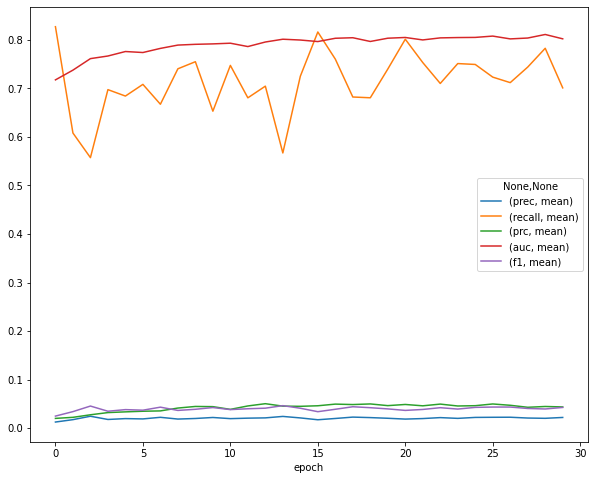




 ===================2 ==============
in shift function: (76462, 2, 11) (76462, 2, 10, 4) 623.0 label
kfold: 1,                 train size: 57346,                 test size: 19116,                 train Y: 467.0,                test Y: 156.0
conv shape: (None, 2, 10, 60)
Model: "model_tcn"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_words (InputLayer)       [(None, 2, 10, 4)]   0           []                               
                                                                                                  
 batch_normalization_72 (BatchN  (None, 2, 10, 4)    16          ['input_words[0][0]']            
 ormalization)                                                                                    
                                                                                                  
 zero_padding2

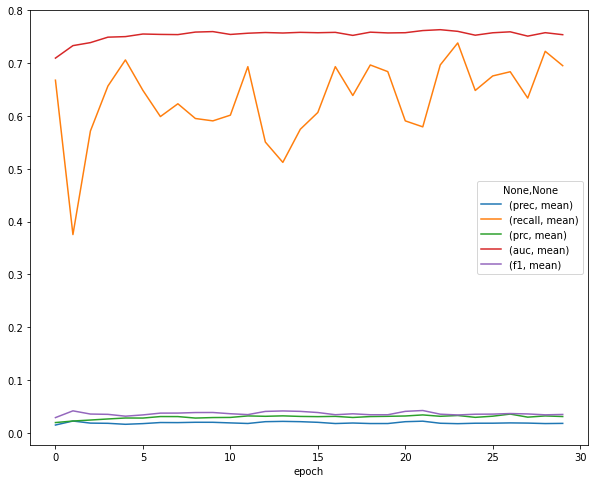




 ===================1 ==============
in shift function: (87765, 1, 11) (87765, 1, 10, 4) 720.0 label
kfold: 1,                 train size: 65823,                 test size: 21942,                 train Y: 540.0,                test Y: 180.0
conv shape: (None, 1, 10, 60)
Model: "model_tcn"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_words (InputLayer)       [(None, 1, 10, 4)]   0           []                               
                                                                                                  
 batch_normalization_84 (BatchN  (None, 1, 10, 4)    16          ['input_words[0][0]']            
 ormalization)                                                                                    
                                                                                                  
 zero_padding2

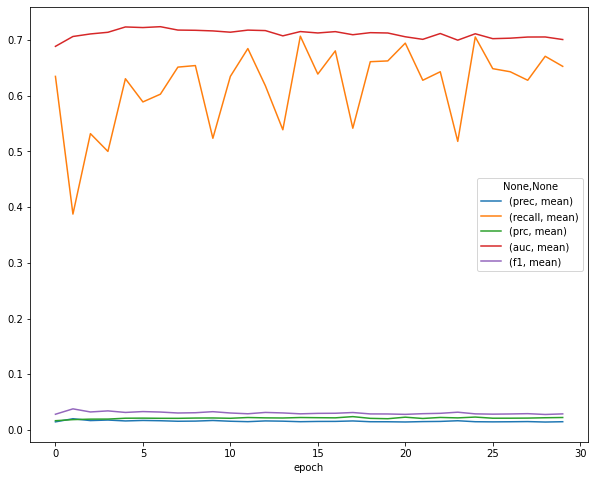

In [55]:
file = "data/final/metrics_granular_merged.pkl"

data = pd.read_pickle(file)
data.columns
key_cols = ["cik", "y1", "y2"]
data = data.sort_values(by = key_cols)
   
total_change_col = "s_max"
target_col = 'label'
fin_cols = ['ch_rec', 'soft_asset', 'ch_cs', 'ch_roa', 'issue', 
            'asset_turnover', 'rg', 'depi', 'gmi',  'opm', 
            #'ch_inv',   #'aqi', #'sg', #'sgee'
           ]

word_cols = []

for c in WORD_CATS:
    #word_cols += [c+ "_p", c+ "_n", c+ "_new",c+ "_dis"]
    word_cols += [c+ "_up", c+ "_down", c+ "_add",c+ "_del"]

data = data[key_cols + fin_cols +  word_cols + [total_change_col] + [target_col]]

# add total change to fin_cols since it's not reshaped
fin_cols += [total_change_col]

len(data)
data.head()
data[target_col].sum()

for w in [3,2,1]:

  print(f'\n\n\n ==================={w} ==============')
  class_weight ={0:1, 1:100}

  hists = cross_validate(data, target_col, fin_cols, word_cols, w=w, num_epoch=30, cv =4, name = "model",\
                         num_filter = 60, metrics_per_word=4, lstm_units = 40, dense_units = 40, \
                         class_weight = class_weight, lr=0.0008, verbose = 2)
  results, agg_results = result_analysis(hists)
  results.to_csv("results/metric_granular_no_sampling_" + str(w) + ".csv", header= True, index = False)

##### Our Granula Metrics - BERT

Index(['cik', 'y1', 'y2', 'Achieve_add', 'Achieve_del', 'Achieve_down',
       'Achieve_up', 'Compare_add', 'Compare_del', 'Compare_down',
       'Compare_up', 'Discrep_add', 'Discrep_del', 'Discrep_down',
       'Discrep_up', 'Litigious_add', 'Litigious_del', 'Litigious_down',
       'Litigious_up', 'Negative_add', 'Negative_del', 'Negative_down',
       'Negative_up', 'Positive_add', 'Positive_del', 'Positive_down',
       'Positive_up', 'Reward_add', 'Reward_del', 'Reward_down', 'Reward_up',
       'StrongModal_add', 'StrongModal_del', 'StrongModal_down',
       'StrongModal_up', 'Uncertainty_add', 'Uncertainty_del',
       'Uncertainty_down', 'Uncertainty_up', 'WeakModal_add', 'WeakModal_del',
       'WeakModal_down', 'WeakModal_up', 's_max', 's_max_orig', 's_min',
       'ch_rec', 'soft_asset', 'ch_cs', 'ch_roa', 'issue', 'asset_turnover',
       'rg', 'depi', 'gmi', 'opm', 'label'],
      dtype='object')

87765

,cik,y1,y2,ch_rec,soft_asset,ch_cs,ch_roa,issue,asset_turnover,rg,...,Achieve_up,Achieve_down,Achieve_add,Achieve_del,Reward_up,Reward_down,Reward_add,Reward_del,s_max_orig,label
0,20,1995,1996,-0.072425,0.661974,-0.208195,0.168310,1.0,1.624273,0.783539,...,0.034483,0.275862,0.008547,0.007822,0.034483,0.103448,0.004274,0.002002,0.689966,0
1,20,1996,1997,-0.018252,0.620435,-0.066028,0.034753,1.0,1.606518,0.938786,...,0.100000,0.133333,0.000000,0.000000,0.100000,0.100000,0.025253,0.000000,0.855465,0
2,20,1997,1998,0.066711,0.656729,-0.030720,0.019574,1.0,1.574474,1.241132,...,0.035714,0.357143,0.008147,0.015463,0.071429,0.250000,0.003312,0.009259,0.567531,0
3,20,1998,1999,0.026323,0.676757,0.011434,0.002424,1.0,1.604656,1.077020,...,0.085714,0.114286,0.009770,0.009726,0.114286,0.028571,0.013533,0.003901,0.738266,0
4,20,1999,2000,-0.024929,0.705573,-0.001713,-0.014429,1.0,1.560280,0.933610,...,0.058824,0.029412,0.000000,0.005956,0.058824,0.029412,0.000000,0.013065,0.788262,0


720




 ===================3 ==============
in shift function: (66511, 3, 11) (66511, 3, 10, 4) 538.0 label
kfold: 1,                 train size: 49883,                 test size: 16628,                 train Y: 404.0,                test Y: 134.0
conv shape: (None, 3, 10, 60)
Model: "model_tcn"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_words (InputLayer)       [(None, 3, 10, 4)]   0           []                               
                                                                                                  
 batch_normalization_24 (BatchN  (None, 3, 10, 4)    16          ['input_words[0][0]']            
 ormalization)                                                                                    
                                                                                                  
 zero_padding2

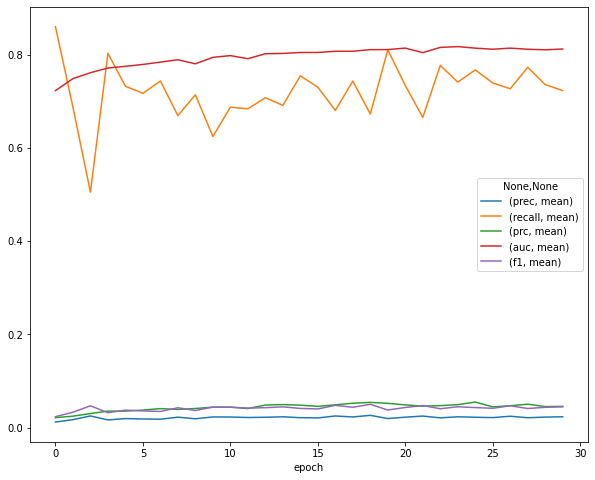




 ===================2 ==============
in shift function: (76462, 2, 11) (76462, 2, 10, 4) 623.0 label
kfold: 1,                 train size: 57346,                 test size: 19116,                 train Y: 467.0,                test Y: 156.0
conv shape: (None, 2, 10, 60)
Model: "model_tcn"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_words (InputLayer)       [(None, 2, 10, 4)]   0           []                               
                                                                                                  
 batch_normalization_36 (BatchN  (None, 2, 10, 4)    16          ['input_words[0][0]']            
 ormalization)                                                                                    
                                                                                                  
 zero_padding2

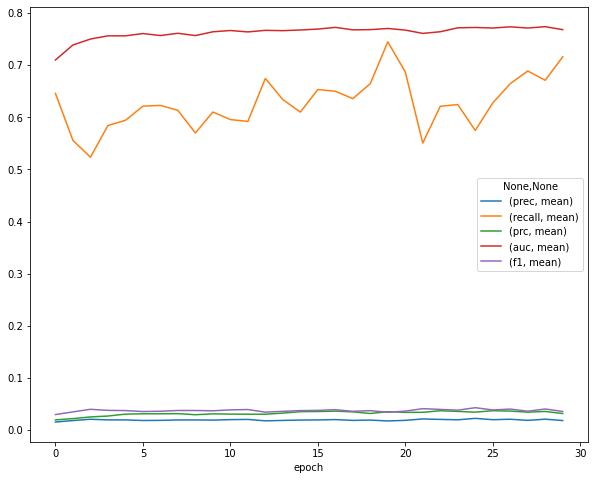




 ===================1 ==============
in shift function: (87765, 1, 11) (87765, 1, 10, 4) 720.0 label
kfold: 1,                 train size: 65823,                 test size: 21942,                 train Y: 540.0,                test Y: 180.0
conv shape: (None, 1, 10, 60)
Model: "model_tcn"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_words (InputLayer)       [(None, 1, 10, 4)]   0           []                               
                                                                                                  
 batch_normalization_48 (BatchN  (None, 1, 10, 4)    16          ['input_words[0][0]']            
 ormalization)                                                                                    
                                                                                                  
 zero_padding2

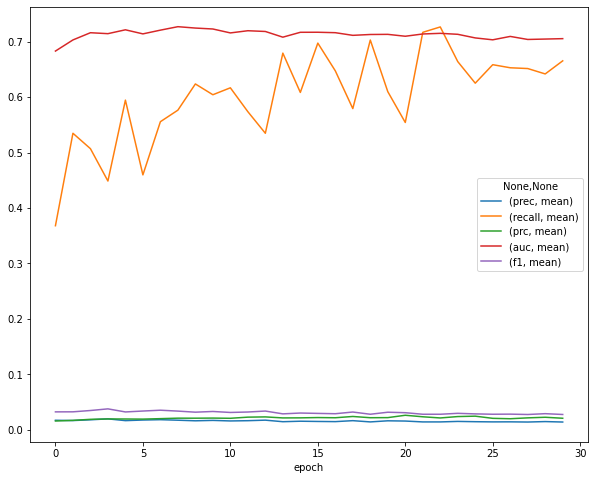

In [53]:
file = "data/final/metrics_granular_merged_bert.pkl"

data = pd.read_pickle(file)
data.columns
key_cols = ["cik", "y1", "y2"]
data = data.sort_values(by = key_cols)
   
total_change_col = "s_max_orig"
target_col = 'label'
fin_cols = ['ch_rec', 'soft_asset', 'ch_cs', 'ch_roa', 'issue', 
            'asset_turnover', 'rg', 'depi', 'gmi',  'opm', 
            #'ch_inv',   #'aqi', #'sg', #'sgee'
           ]

word_cols = []

for c in WORD_CATS:
    #word_cols += [c+ "_p", c+ "_n", c+ "_new",c+ "_dis"]
    word_cols += [c+ "_up", c+ "_down", c+ "_add",c+ "_del"]

data = data[key_cols + fin_cols +  word_cols + [total_change_col] + [target_col]]

# add total change to fin_cols since it's not reshaped
fin_cols += [total_change_col]

len(data)
data.head()
data[target_col].sum()

for w in [3,2,1]:

  print(f'\n\n\n ==================={w} ==============')
  class_weight ={0:1, 1:100}

  hists = cross_validate(data, target_col, fin_cols, word_cols, w=w, num_epoch=30, cv =4, name = "model",\
                         num_filter = 60, metrics_per_word=4, lstm_units = 40, dense_units = 40, \
                         class_weight = class_weight, lr=0.0008, verbose = 2)
  results, agg_results = result_analysis(hists)
  results.to_csv("results/metric_granular_bert_no_sampling_" + str(w) + ".csv", header= True, index = False)

## Sampling + Cross Validation

### Our matched similarity

In [ ]:
file = "data/final/metrics_granular_merged.pkl"

data = pd.read_pickle(file)
data.columns
key_cols = ["cik", "y1", "y2"]
data = data.sort_values(by = key_cols)
   
total_change_col = "s_max"
target_col = 'label'

word_cols = []

for c in WORD_CATS:
    #word_cols += [c+ "_p", c+ "_n", c+ "_new",c+ "_dis"]
    word_cols += [c+ "_up", c+ "_down", c+ "_add",c+ "_del"]

data = data[key_cols + fin_cols +  word_cols + [total_change_col] + [target_col]]

# add total change to fin_cols since it's not reshaped
fin_cols += [total_change_col]

len(data)
data.head()
data[target_col].sum()

for w in [3,2,1]:

  print(f'\n\n\n ==================={w} ==============')
  hists = repeated_sampling_cv(data, target_col, fin_cols, word_cols, w=w, num_epoch=200, cv =4, name = "model",\
                         rounds = 5, num_filter = 48, metrics_per_word=4, lstm_units = 32, dense_units = 32, \
                         class_weight = None, lr=0.0008, verbose = 2)
  results, agg_results = result_analysis(hists)
  #results.to_csv("results/metric_granular" + str(w) + ".csv", header= True, index = False)


In [ ]:
# x = shift_data(data, 3, [total_change_col]+fin_cols,word_cols, target_col, False)
# x = shift_data(data, 2, [total_change_col]+fin_cols,word_cols, target_col, False)
# x = shift_data(data, 1, [total_change_col]+fin_cols,word_cols, target_col, False)

### Unmatched Overall Changes (+/- per word)

In [ ]:
file = "data/final/modify_score_unmatch_merged.pkl"

data = pd.read_pickle(file)
key_cols = ["cik", "y1", "y2"]
data = data.sort_values(by = key_cols)

total_change_col = "unmatch_total_change"
target_col = 'label'

word_cols = []
for c in WORD_CATS:
    word_cols += ["unmatch_" + c+ "+",
                  "unmatch_" + c+ "-"]

data =  get_data(data, key_cols, word_cols, fin_cols, total_change_col, target_col)

len(data)
data.head()
data[target_col].sum()

data[word_cols+fin_cols+[total_change_col]+[target_col]].describe()

for w in [3,2,1]:
   print(f'\n\n\n ==================={w} ==============')

   hists = repeated_sampling_cv(data, target_col, fin_cols, word_cols, w=w, num_epoch=200, cv =4, name = "model",\
                         rounds = 1, num_filter = 60, metrics_per_word=2, lstm_units = 40, dense_units = 32, \
                         class_weight = None, lr=0.0008, verbose = 2)
   results, agg_results = result_analysis(hists)
   
   results.to_csv("results/metric_unmatch" + str(w) + ".csv", header= True, index = False)

In [ ]:
x = shift_data(data, 3, [total_change_col]+fin_cols,word_cols, target_col, False, metrics_per_word = 2)
x = shift_data(data, 2, [total_change_col]+fin_cols,word_cols, target_col, False, metrics_per_word = 2)
x = shift_data(data, 1, [total_change_col]+fin_cols,word_cols, target_col, False, metrics_per_word = 2)

In [ ]:
rounds = 2

for w in [3,2,1]: # time window
 
  hists = run_function_dl_kf(
    w, [total_change_col]+fin_cols, word_cols, target_col, my_filter, data, my_epoch, \
    baseline=False, metrics_per_word = 2, lr=0.0008, rounds=rounds, verbose = 0)

  results, agg_results = result_analysis(hists)
  results.to_csv("results/metric_unmatch_win" + str(w) + "_full_model.csv", header= True, index = False)

## Walk Through

### Walk Through: Granular

In [ ]:
def run_out_of_sample_test(file, num_epoch=200, rounds = 2, num_filter = 48, 
                         metrics_per_word=4, lstm_units = 32, \
                           result_file = 'out_of_sample.csv'):

    set_seed()
    #file = "data/final/metrics_granular_merged.pkl"
    WORD_CATS = ['WeakModal','Uncertainty', 'Negative', 'Litigious',  \
                 'StrongModal', 'Reward',  'Compare', \
                 'Positive','Discrep','Achieve']
    
#     WORD_CATS = ['WeakModal',
#              'Uncertainty',
#              'Negative', \
#              'Compare', 'Positive', 'Litigious',\
#            'StrongModal','Discrep','Achieve',  'Reward']


    data = pd.read_pickle(file)

    key_cols = ["cik", "y1", "y2"]
    data = data.sort_values(by = key_cols)
    data = data.reset_index(drop = True)

    total_change_col = "s_max"
    target_col = 'label'
    fin_cols = ['ch_rec', 'soft_asset', 'ch_cs', 'ch_roa', 'issue', 
                'asset_turnover', 'rg', 'depi', 'gmi',  'opm', 
                #'ch_inv',   #'aqi', #'sg', #'sgee'
               ]

    words_cols = []

    for c in WORD_CATS:
        words_cols += [c+ "_up", c+ "_down", c+ "_add",c+ "_del"]

    data = data[key_cols + fin_cols +  words_cols + [total_change_col] + [target_col]]
    
    # add total change to fin_cols since it's not reshaped
    fin_cols += [total_change_col]

    all_results = pd.DataFrame([])

    cut_points = [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2018]
    
    for i in range(len(cut_points)-1):
        
      start_year = cut_points[i]
      end_year = cut_points[i+1]
      print("\n===============",start_year, end_year, "==================")

      hists = sampling_with_test(data,label = target_col, \
                             perf_cols = fin_cols, words_cols = words_cols, 
                           name = "model", w = 3, num_epoch = num_epoch, \
                           cutoff = [start_year, end_year],
                           rounds = rounds, num_filter = num_filter, \
                                 metrics_per_word=metrics_per_word, 
                           lstm_units = lstm_units, dense_units = 32, \
                           class_weight = None, lr=0.0008, verbose = 0)
  

      results, agg_results = result_analysis(hists)
      results["year"] = start_year
      all_results = all_results.append(results)

      all_results.to_csv(result_file, header= True, index = False) 

      print("\n\n =========================\n\n")

    all_results.to_csv(result_file, header= True, index = False)   
    print(f'\n =========== Complete !!!============\n\n\n ')

In [ ]:
run_out_of_sample_test(file = "data/metrics_granular_merged.pkl",\
                        num_epoch=200, rounds = 100, num_filter = 60, \
                        metrics_per_word=4, lstm_units = 40,\
                        result_file = 'results/granular_out_of_sample_60_40.csv')

In [ ]:
# Test shift function

file = "data/final/metrics_granular_merged.pkl"

data = pd.read_pickle(file)
data = data.reset_index(drop = True)
key_cols = ["cik", "y1", "y2"]

total_change_col = "s_max"
target_col = 'label'
fin_cols = ['ch_rec', 'soft_asset', 'ch_cs', 'ch_roa', 'issue', 
            'asset_turnover', 'rg', 'depi', 'gmi',  'opm', 
            #'ch_inv',   #'aqi', #'sg', #'sgee'
           ]

word_cols = []
for c in WORD_CATS:
    word_cols += [c+ "_up", c+ "_down", c+ "_add",c+ "_del"]



all_results = pd.DataFrame([])

X_train_perf, X_train_word, Y_train = shift_data(data.astype('float'), w,
                                   fin_cols,
                                   word_cols,
                                   target_col,
                                   metrics_per_word = 4)
    
cut_points = [2009, 2010, 2011, 2012, 2013, 2018]
w = 3

for i in range(len(cut_points)-1):
    start_year = cut_points[i]
    end_year = cut_points[i+1]

    data_train = data[data.y2 < start_year]

    data_train  =  get_data(data_train, key_cols, word_cols, fin_cols, total_change_col, target_col)
    data_train = data_train.sort_values(by=['cik', 'y2'])
    X_train_perf, X_train_word, Y_train = shift_data(data_train.astype('float'), w,
                                   fin_cols,
                                   word_cols,
                                   target_col,
                                   metrics_per_word = 4)
    
    data_test  =  get_data(data, key_cols, word_cols, fin_cols, total_change_col, target_col)
    data_test = data_test.sort_values(by=['cik', 'y2'])
    X_test_perf, X_test_word, Y_test = shift_data_with_cutoff(data.astype('float'), w,
                                   fin_cols,
                                   word_cols,
                                   target_col,
                                   cutoff = [start_year, end_year],                          
                                   metrics_per_word = 4)
    
    print("\n===============",start_year, end_year, "==================")
    print(X_train_word.shape, X_test_word.shape)
    print("target:", Y_train.sum(), Y_test.sum())
    print("==================================================\n")
  



In [ ]:
file = "data/final/metrics_granular_merged.pkl"

data = pd.read_pickle(file)
data = data.reset_index(drop = True)
key_cols = ["cik", "y1", "y2"]

total_change_col = "s_max"
target_col = 'label'
fin_cols = ['ch_rec', 'soft_asset', 'ch_cs', 'ch_roa', 'issue', 
            'asset_turnover', 'rg', 'depi', 'gmi',  'opm', 
            #'ch_inv',   #'aqi', #'sg', #'sgee'
           ]

words_cols = []

for c in WORD_CATS:
    words_cols += [c+ "_up", c+ "_down", c+ "_add",c+ "_del"]

data = data[key_cols + fin_cols +  words_cols + [total_change_col] + [target_col]]
data = data.sort_values(by = key_cols)

# add total change to fin_cols since it's not reshaped
fin_cols += [total_change_col]

all_results = pd.DataFrame([])

cut_points = [2009, 2010, 2011, 2012, 2018]
for i in range(len(cut_points)-1):
  start_year = cut_points[i]
  end_year = cut_points[i+1]

  hists = sampling_with_test(data,label = target_col, \
                             perf_cols = fin_cols, words_cols = words_cols, 
                           name = "model", w = 3, num_epoch = 200, \
                           cutoff = [start_year, end_year],
                           rounds = 5, num_filter = 60, metrics_per_word=4, 
                           lstm_units = 40, dense_units = 32, \
                           class_weight = None, lr=0.0005, verbose = 2)
  

  results, agg_results = result_analysis(hists)
  results["year"] = start_year
  all_results = all_results.append(results)

  print("\n\n =========================\n\n")

all_results.to_csv("results/out_of_sample.csv", header= True, index = False)

  

### Walk Through : Unmatched, out of sampel test
    

In [ ]:
def run_out_of_sample_test_unmatch(file, num_epoch=200, rounds = 2, num_filter = 48, 
                         metrics_per_word=4, lstm_units = 32, \
                           result_file = 'out_of_sample.csv'):

    #file = "data/final/metrics_granular_merged.pkl"

    data = pd.read_pickle(file)

    key_cols = ["cik", "y1", "y2"]
    
    data = data.sort_values(by = key_cols)
    data = data.reset_index(drop = True)

    total_change_col = "unmatch_total_change"
    
    target_col = 'label'
    fin_cols = ['ch_rec', 'soft_asset', 'ch_cs', 'ch_roa', 'issue', 
                'asset_turnover', 'rg', 'depi', 'gmi',  'opm' 
                #'ch_inv',   #'aqi', #'sg', #'sgee'
               ]

    words_cols = []

    for c in WORD_CATS:
        words_cols += ["unmatch_" + c+ "+",
                  "unmatch_" + c+ "-"]

    data = data[key_cols + fin_cols +  words_cols + [total_change_col] + [target_col]]
    #print("null value : ", data.loc[pd.isna(data).any(axis =1)])
    
    # add total change to fin_cols since it's not reshaped
    fin_cols += [total_change_col]

    all_results = pd.DataFrame([])

    #cut_points = [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2018]
    cut_points = [2010, 2011]
    
    for i in range(len(cut_points)-1):
        
      start_year = cut_points[i]
      end_year = cut_points[i+1]
        
      print("\n===============",start_year, end_year, "==================")

      hists = sampling_with_test(data,label = target_col, \
                             perf_cols = fin_cols, words_cols = words_cols, 
                           name = "model", w = 3, num_epoch = num_epoch, \
                           cutoff = [start_year, end_year],
                           rounds = rounds, num_filter = num_filter, \
                                 metrics_per_word=metrics_per_word, 
                           lstm_units = lstm_units, dense_units = 32, \
                           class_weight = None, lr=0.0005, verbose = 2)
  

      results, agg_results = result_analysis(hists)
      results["year"] = start_year
      all_results = all_results.append(results)

      #all_results.to_csv(result_file, header= True, index = False) 

      print("\n\n =========================\n\n")

    #all_results.to_csv(result_file, header= True, index = False)   
    print(f'\n =========== Complete !!!============\n\n\n ')
    
    return all_results

In [ ]:
run_out_of_sample_test_unmatch(file = "data/final/modify_score_unmatch_merged.pkl",\
                        num_epoch=200, rounds = 5, num_filter = 60, \
                        metrics_per_word=2, lstm_units = 40,\
                       result_file = 'results/unmatch_out_of_sample.csv')

## Baseline

### Without Random Sampling; Cross Validation

#### Baseline: - Trajectory only

Index(['cik', 'y1', 'y2', 'Achieve_add', 'Achieve_del', 'Achieve_down',
       'Achieve_up', 'Compare_add', 'Compare_del', 'Compare_down',
       'Compare_up', 'Discrep_add', 'Discrep_del', 'Discrep_down',
       'Discrep_up', 'Litigious_add', 'Litigious_del', 'Litigious_down',
       'Litigious_up', 'Negative_add', 'Negative_del', 'Negative_down',
       'Negative_up', 'Positive_add', 'Positive_del', 'Positive_down',
       'Positive_up', 'Reward_add', 'Reward_del', 'Reward_down', 'Reward_up',
       'StrongModal_add', 'StrongModal_del', 'StrongModal_down',
       'StrongModal_up', 'Uncertainty_add', 'Uncertainty_del',
       'Uncertainty_down', 'Uncertainty_up', 'WeakModal_add', 'WeakModal_del',
       'WeakModal_down', 'WeakModal_up', 's_max', 's_max_orig', 's_min',
       'ch_rec', 'soft_asset', 'ch_cs', 'ch_roa', 'issue', 'asset_turnover',
       'rg', 'depi', 'gmi', 'opm', 'label'],
      dtype='object')

87765

,cik,y1,y2,ch_rec,soft_asset,ch_cs,ch_roa,issue,asset_turnover,rg,...,Discrep_up,Discrep_down,Discrep_add,Discrep_del,Achieve_up,Achieve_down,Achieve_add,Achieve_del,s_max_orig,label
0,20,1995,1996,-0.072425,0.661974,-0.208195,0.168310,1.0,1.624273,0.783539,...,0.172414,0.068966,0.000000,0.008677,0.034483,0.275862,0.008547,0.007822,0.689966,0
1,20,1996,1997,-0.018252,0.620435,-0.066028,0.034753,1.0,1.606518,0.938786,...,0.033333,0.133333,0.027778,0.000000,0.100000,0.133333,0.000000,0.000000,0.855465,0
2,20,1997,1998,0.066711,0.656729,-0.030720,0.019574,1.0,1.574474,1.241132,...,0.142857,0.071429,0.009016,0.022117,0.035714,0.357143,0.008147,0.015463,0.567531,0
3,20,1998,1999,0.026323,0.676757,0.011434,0.002424,1.0,1.604656,1.077020,...,0.057143,0.057143,0.014353,0.006807,0.085714,0.114286,0.009770,0.009726,0.738266,0
4,20,1999,2000,-0.024929,0.705573,-0.001713,-0.014429,1.0,1.560280,0.933610,...,0.117647,0.147059,0.000000,0.008065,0.058824,0.029412,0.000000,0.005956,0.788262,0


720




 ===================2 ==============
in shift function: (76462, 2, 1) (76462, 2, 10, 4) 623.0 label
kfold: 1,                 train size: 57346,                 test size: 19116,                 train Y: 467.0,                test Y: 156.0
conv shape: (None, 2, 10, 60)
Model: "model_tcn"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_words (InputLayer)       [(None, 2, 10, 4)]   0           []                               
                                                                                                  
 batch_normalization_771 (Batch  (None, 2, 10, 4)    16          ['input_words[0][0]']            
 Normalization)                                                                                   
                                                                                                  
 zero_padding2d

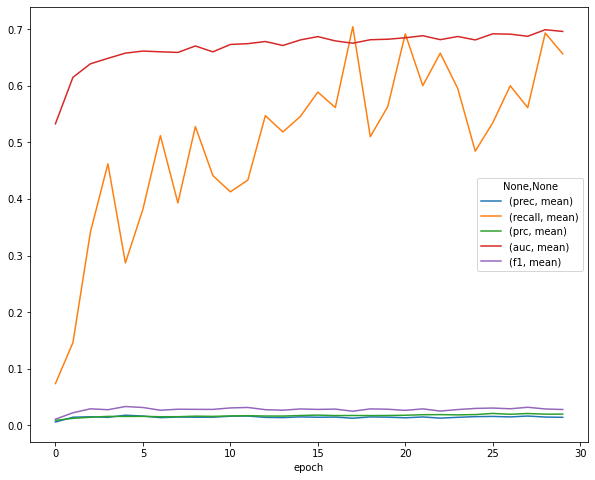




 ===================3 ==============
in shift function: (66511, 3, 1) (66511, 3, 10, 4) 538.0 label
kfold: 1,                 train size: 49883,                 test size: 16628,                 train Y: 404.0,                test Y: 134.0
conv shape: (None, 3, 10, 60)
Model: "model_tcn"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_words (InputLayer)       [(None, 3, 10, 4)]   0           []                               
                                                                                                  
 batch_normalization_783 (Batch  (None, 3, 10, 4)    16          ['input_words[0][0]']            
 Normalization)                                                                                   
                                                                                                  
 zero_padding2d

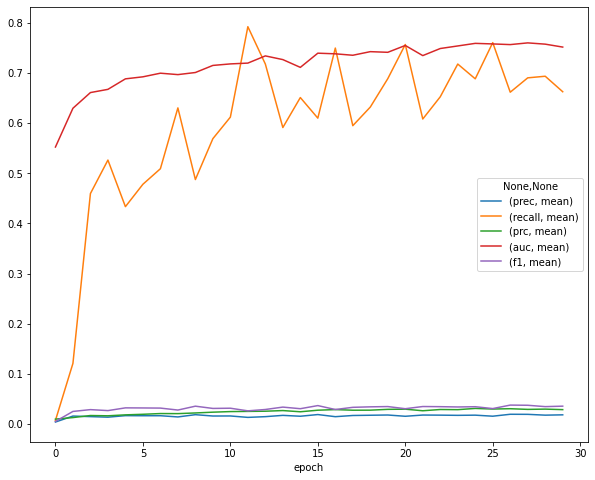

In [90]:
file = "data/final/metrics_granular_merged_bert.pkl"

set_seed()

WORD_CATS = ['WeakModal','Uncertainty', 'Negative', 'Litigious',  \
                 'StrongModal', 'Reward',  'Compare', \
                 'Positive','Discrep','Achieve']

fin_cols = ['ch_rec', 'soft_asset', 'ch_cs', 'ch_roa', 'issue', 
            'asset_turnover', 'rg', 'depi', 'gmi',  'opm', 
            #'ch_inv',   #'aqi', #'sg', #'sgee'
           ]

data = pd.read_pickle(file)
data.columns
key_cols = ["cik", "y1", "y2"]
data = data.sort_values(by = key_cols)
   
total_change_col = "s_max_orig"
target_col = 'label'

word_cols = []

for c in WORD_CATS:
    #word_cols += [c+ "_p", c+ "_n", c+ "_new",c+ "_dis"]
    word_cols += [c+ "_up", c+ "_down", c+ "_add",c+ "_del"]

data = data[key_cols + fin_cols +  word_cols + [total_change_col] + [target_col]]

# only have s_max in fin_cols
fin_cols = [total_change_col]

len(data)
data.head()
data[target_col].sum()

for w in [2,3]:
  class_weight ={0:1, 1:100}

  print(f'\n\n\n ==================={w} ==============')
  # hists = repeated_sampling_cv(data, target_col, fin_cols, word_cols, w=w, num_epoch=200, cv =4, name = "model",\
  #                        rounds = 15, num_filter = 60, metrics_per_word=4, lstm_units = 40, dense_units = 32, \
  #                        class_weight = None, lr=0.0008, verbose = 0)
  
  hists = cross_validate(data, target_col, fin_cols, word_cols, w=w, num_epoch=30, cv =4, name = "model",\
                         num_filter = 60, metrics_per_word=4, lstm_units = 40, dense_units = 40, \
                         class_weight = class_weight, lr=0.0008, verbose = 0)
  
  results, agg_results = result_analysis(hists)
  results.to_csv("results/trajectory_only_no_sampling_bert_" + str(w) + ".csv", header= True, index = False)

#### Baseline: Without word change metrics

In [ ]:
file = "data/final/metrics_granular_merged_bert.pkl"

set_seed()

WORD_CATS = ['WeakModal','Uncertainty', 'Negative', 'Litigious',  \
                 'StrongModal', 'Reward',  'Compare', \
                 'Positive','Discrep','Achieve']

fin_cols = ['ch_rec', 'soft_asset', 'ch_cs', 'ch_roa', 'issue', 
            'asset_turnover', 'rg', 'depi', 'gmi',  'opm', 
            #'ch_inv',   #'aqi', #'sg', #'sgee'
           ]

data = pd.read_pickle(file)
data.columns
key_cols = ["cik", "y1", "y2"]
data = data.sort_values(by = key_cols)
   
total_change_col = "s_max_orig"
target_col = 'label'

word_cols = []

for c in WORD_CATS:
    #word_cols += [c+ "_p", c+ "_n", c+ "_new",c+ "_dis"]
    word_cols += [c+ "_up", c+ "_down", c+ "_add",c+ "_del"]

data = data[key_cols + fin_cols +  word_cols + [total_change_col] + [target_col]]

# only have s_max in fin_cols
fin_cols += [total_change_col]

len(data)
data.head()
data[target_col].sum()

for w in [3,2,1]:
  class_weight ={0:1, 1:100}
  print(f'\n\n\n ==================={w} ==============')

  hists = cross_validate_lstm_only(data, target_col, fin_cols, num_epoch=200, cv =4, name = "model",\
                         lstm_units = 40, dense_units = 64, \
                         class_weight = class_weight, lr=0.0005, verbose = 0)
  
  results, agg_results = result_analysis(hists)
  results.to_csv("results/wo_word_metrics_bert_no_sampling_" + str(w) + ".csv", header= True, index = False)

Index(['cik', 'y1', 'y2', 'Achieve_add', 'Achieve_del', 'Achieve_down',
       'Achieve_up', 'Compare_add', 'Compare_del', 'Compare_down',
       'Compare_up', 'Discrep_add', 'Discrep_del', 'Discrep_down',
       'Discrep_up', 'Litigious_add', 'Litigious_del', 'Litigious_down',
       'Litigious_up', 'Negative_add', 'Negative_del', 'Negative_down',
       'Negative_up', 'Positive_add', 'Positive_del', 'Positive_down',
       'Positive_up', 'Reward_add', 'Reward_del', 'Reward_down', 'Reward_up',
       'StrongModal_add', 'StrongModal_del', 'StrongModal_down',
       'StrongModal_up', 'Uncertainty_add', 'Uncertainty_del',
       'Uncertainty_down', 'Uncertainty_up', 'WeakModal_add', 'WeakModal_del',
       'WeakModal_down', 'WeakModal_up', 's_max', 's_max_orig', 's_min',
       'ch_rec', 'soft_asset', 'ch_cs', 'ch_roa', 'issue', 'asset_turnover',
       'rg', 'depi', 'gmi', 'opm', 'label'],
      dtype='object')

87765

,cik,y1,y2,ch_rec,soft_asset,ch_cs,ch_roa,issue,asset_turnover,rg,...,Discrep_up,Discrep_down,Discrep_add,Discrep_del,Achieve_up,Achieve_down,Achieve_add,Achieve_del,s_max_orig,label
0,20,1995,1996,-0.072425,0.661974,-0.208195,0.168310,1.0,1.624273,0.783539,...,0.172414,0.068966,0.000000,0.008677,0.034483,0.275862,0.008547,0.007822,0.689966,0
1,20,1996,1997,-0.018252,0.620435,-0.066028,0.034753,1.0,1.606518,0.938786,...,0.033333,0.133333,0.027778,0.000000,0.100000,0.133333,0.000000,0.000000,0.855465,0
2,20,1997,1998,0.066711,0.656729,-0.030720,0.019574,1.0,1.574474,1.241132,...,0.142857,0.071429,0.009016,0.022117,0.035714,0.357143,0.008147,0.015463,0.567531,0
3,20,1998,1999,0.026323,0.676757,0.011434,0.002424,1.0,1.604656,1.077020,...,0.057143,0.057143,0.014353,0.006807,0.085714,0.114286,0.009770,0.009726,0.738266,0
4,20,1999,2000,-0.024929,0.705573,-0.001713,-0.014429,1.0,1.560280,0.933610,...,0.117647,0.147059,0.000000,0.008065,0.058824,0.029412,0.000000,0.005956,0.788262,0


720




 ===================3 ==============
in shift function: (66511, 3, 11) 538.0 label
kfold: 1,                 train size: 49883,                 test size: 16628,                 train Y: 404.0,                test Y: 134.0
Model: "model_lstm_only"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_perf (InputLayer)     [(None, 3, 11)]           0         
                                                                 
 batch_normalization_798 (Ba  (None, 3, 11)            44        
 tchNormalization)                                               
                                                                 
 bidirectional_588 (Bidirect  (None, 3, 80)            16640     
 ional)                                                          
                                                                 
 layer_lstm_2 (LSTM)         (None, 40)                19360     
                       

#### Baseline: without trajectory

In [ ]:
file = "data/final/metrics_granular_merged_bert.pkl"

set_seed()

WORD_CATS = ['WeakModal','Uncertainty', 'Negative', 'Litigious',  \
                 'StrongModal', 'Reward',  'Compare', \
                 'Positive','Discrep','Achieve']

fin_cols = ['ch_rec', 'soft_asset', 'ch_cs', 'ch_roa', 'issue', 
            'asset_turnover', 'rg', 'depi', 'gmi',  'opm', 
            #'ch_inv',   #'aqi', #'sg', #'sgee'
           ]

data = pd.read_pickle(file)
data.columns
key_cols = ["cik", "y1", "y2"]
data = data.sort_values(by = key_cols)
   
total_change_col = "s_max_orig"
target_col = 'label'

word_cols = []

for c in WORD_CATS:
    #word_cols += [c+ "_p", c+ "_n", c+ "_new",c+ "_dis"]
    word_cols += [c+ "_up", c+ "_down", c+ "_add",c+ "_del"]

data = data[key_cols + fin_cols +  word_cols + [total_change_col] + [target_col]]

# only have s_max in fin_cols
#fin_cols += [total_change_col]

len(data)
data.head()
data[target_col].sum()

for w in [3,2,1]:
  class_weight ={0:1, 1:100}
  print(f'\n\n\n ==================={w} ==============')

  hists = cross_validate_lstm_only(data, target_col, fin_cols, num_epoch=200, cv =4, name = "model",\
                         lstm_units = 40, dense_units = 64, \
                         class_weight = class_weight, lr=0.0005, verbose = 0)
  
  results, agg_results = result_analysis(hists)
  results.to_csv("results/wo_trajectory_bert_no_sampling_" + str(w) + ".csv", header= True, index = False)

#### Baseline: without TCN

In [ ]:
file = "data/final/metrics_granular_merged_bert.pkl"

set_seed()

WORD_CATS = ['WeakModal','Uncertainty', 'Negative', 'Litigious',  \
                 'StrongModal', 'Reward',  'Compare', \
                 'Positive','Discrep','Achieve']

fin_cols = ['ch_rec', 'soft_asset', 'ch_cs', 'ch_roa', 'issue', 
            'asset_turnover', 'rg', 'depi', 'gmi',  'opm', 
            #'ch_inv',   #'aqi', #'sg', #'sgee'
           ]

data = pd.read_pickle(file)
data.columns
key_cols = ["cik", "y1", "y2"]
data = data.sort_values(by = key_cols)
   
total_change_col = "s_max_orig"
target_col = 'label'

word_cols = []

for c in WORD_CATS:
    #word_cols += [c+ "_p", c+ "_n", c+ "_new",c+ "_dis"]
    word_cols += [c+ "_up", c+ "_down", c+ "_add",c+ "_del"]

data = data[key_cols + fin_cols +  word_cols + [total_change_col] + [target_col]]

# put all columns into fin_cols
fin_cols += [total_change_col] 
fin_cols += word_cols

len(data)
data.head()
data[target_col].sum()

for w in [3,2,1]:
  class_weight ={0:1, 1:100}
  print(f'\n\n\n ==================={w} ==============')

  hists = cross_validate_lstm_only(data, target_col, fin_cols, num_epoch=200, cv =4, name = "model",\
                         lstm_units = 40, dense_units = 64, \
                         class_weight = class_weight, lr=0.0005, verbose = 0)
  
  results, agg_results = result_analysis(hists)
  results.to_csv("results/wo_tcn_bert_no_sampling" + str(w) + ".csv", header= True, index = False)

#### Baseline: LSTM unidirectional

In [ ]:
file = "data/final/metrics_granular_merged_bert.pkl"

set_seed()

WORD_CATS = ['WeakModal','Uncertainty', 'Negative', 'Litigious',  \
                 'StrongModal', 'Reward',  'Compare', \
                 'Positive','Discrep','Achieve']

fin_cols = ['ch_rec', 'soft_asset', 'ch_cs', 'ch_roa', 'issue', 
            'asset_turnover', 'rg', 'depi', 'gmi',  'opm', 
            #'ch_inv',   #'aqi', #'sg', #'sgee'
           ]

data = pd.read_pickle(file)
data.columns
key_cols = ["cik", "y1", "y2"]
data = data.sort_values(by = key_cols)
   
total_change_col = "s_max_orig"
target_col = 'label'

word_cols = []

for c in WORD_CATS:
    #word_cols += [c+ "_p", c+ "_n", c+ "_new",c+ "_dis"]
    word_cols += [c+ "_up", c+ "_down", c+ "_add",c+ "_del"]

data = data[key_cols + fin_cols +  word_cols + [total_change_col] + [target_col]]

# put all columns into fin_cols
fin_cols += [total_change_col] 
fin_cols += word_cols

len(data)
data.head()
data[target_col].sum()

for w in [3,2,1]:
  class_weight ={0:1, 1:100}
  print(f'\n\n\n ==================={w} ==============')

  hists = cross_validate_lstm_only(data, target_col, fin_cols, num_epoch=200, cv =4, name = "model",\
                         lstm_units = 40, dense_units = 64, bidirectional = False, \
                         class_weight = class_weight, lr=0.0005, verbose = 0)
  
  results, agg_results = result_analysis(hists)
  results.to_csv("results/unidirection_lstm_bert_no_sampling" + str(w) + ".csv", header= True, index = False)

### Random Sampling; Cross Validation

#### Baseline: - Trajectory only

Index(['cik', 'y1', 'y2', 'Achieve_add', 'Achieve_del', 'Achieve_down',
       'Achieve_up', 'Compare_add', 'Compare_del', 'Compare_down',
       'Compare_up', 'Discrep_add', 'Discrep_del', 'Discrep_down',
       'Discrep_up', 'Litigious_add', 'Litigious_del', 'Litigious_down',
       'Litigious_up', 'Negative_add', 'Negative_del', 'Negative_down',
       'Negative_up', 'Positive_add', 'Positive_del', 'Positive_down',
       'Positive_up', 'Reward_add', 'Reward_del', 'Reward_down', 'Reward_up',
       'StrongModal_add', 'StrongModal_del', 'StrongModal_down',
       'StrongModal_up', 'Uncertainty_add', 'Uncertainty_del',
       'Uncertainty_down', 'Uncertainty_up', 'WeakModal_add', 'WeakModal_del',
       'WeakModal_down', 'WeakModal_up', 's_max', 's_max_orig', 's_min',
       'ch_rec', 'soft_asset', 'ch_cs', 'ch_roa', 'issue', 'asset_turnover',
       'rg', 'depi', 'gmi', 'opm', 'label'],
      dtype='object')

87765

,cik,y1,y2,ch_rec,soft_asset,ch_cs,ch_roa,issue,asset_turnover,rg,...,Discrep_up,Discrep_down,Discrep_add,Discrep_del,Achieve_up,Achieve_down,Achieve_add,Achieve_del,s_max_orig,label
0,20,1995,1996,-0.072425,0.661974,-0.208195,0.168310,1.0,1.624273,0.783539,...,0.172414,0.068966,0.000000,0.008677,0.034483,0.275862,0.008547,0.007822,0.689966,0
1,20,1996,1997,-0.018252,0.620435,-0.066028,0.034753,1.0,1.606518,0.938786,...,0.033333,0.133333,0.027778,0.000000,0.100000,0.133333,0.000000,0.000000,0.855465,0
2,20,1997,1998,0.066711,0.656729,-0.030720,0.019574,1.0,1.574474,1.241132,...,0.142857,0.071429,0.009016,0.022117,0.035714,0.357143,0.008147,0.015463,0.567531,0
3,20,1998,1999,0.026323,0.676757,0.011434,0.002424,1.0,1.604656,1.077020,...,0.057143,0.057143,0.014353,0.006807,0.085714,0.114286,0.009770,0.009726,0.738266,0
4,20,1999,2000,-0.024929,0.705573,-0.001713,-0.014429,1.0,1.560280,0.933610,...,0.117647,0.147059,0.000000,0.008065,0.058824,0.029412,0.000000,0.005956,0.788262,0


720




 ===================1 ==============
in shift function: (87765, 1, 1) (87765, 1, 10, 4) 720.0 label

===========round: 0, X: (1440,), Y: (1440,) ======
round:  0 kfold:  0 train size:  1080 test size:  360
conv shape: (None, 1, 10, 60)
round:  0 kfold:  1 train size:  1080 test size:  360
conv shape: (None, 1, 10, 60)
round:  0 kfold:  2 train size:  1080 test size:  360
conv shape: (None, 1, 10, 60)
round:  0 kfold:  3 train size:  1080 test size:  360
conv shape: (None, 1, 10, 60)

===========round: 1, X: (1440,), Y: (1440,) ======
round:  1 kfold:  0 train size:  1080 test size:  360
conv shape: (None, 1, 10, 60)
round:  1 kfold:  1 train size:  1080 test size:  360
conv shape: (None, 1, 10, 60)
round:  1 kfold:  2 train size:  1080 test size:  360
conv shape: (None, 1, 10, 60)
round:  1 kfold:  3 train size:  1080 test size:  360
conv shape: (None, 1, 10, 60)

===========round: 2, X: (1440,), Y: (1440,) ======
round:  2 kfold:  0 train size:  1080 test size:  360
conv shape: (No

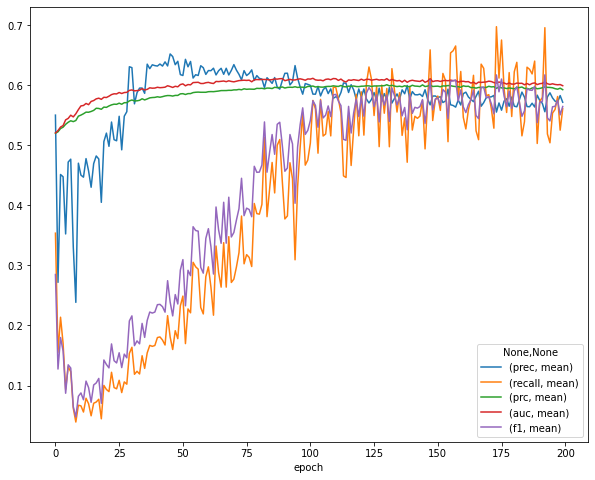

In [56]:
file = "data/final/metrics_granular_merged_bert.pkl"

set_seed()

WORD_CATS = ['WeakModal','Uncertainty', 'Negative', 'Litigious',  \
                 'StrongModal', 'Reward',  'Compare', \
                 'Positive','Discrep','Achieve']

fin_cols = ['ch_rec', 'soft_asset', 'ch_cs', 'ch_roa', 'issue', 
            'asset_turnover', 'rg', 'depi', 'gmi',  'opm', 
            #'ch_inv',   #'aqi', #'sg', #'sgee'
           ]

data = pd.read_pickle(file)
data.columns
key_cols = ["cik", "y1", "y2"]
data = data.sort_values(by = key_cols)
   
total_change_col = "s_max_orig"
target_col = 'label'

word_cols = []

for c in WORD_CATS:
    #word_cols += [c+ "_p", c+ "_n", c+ "_new",c+ "_dis"]
    word_cols += [c+ "_up", c+ "_down", c+ "_add",c+ "_del"]

data = data[key_cols + fin_cols +  word_cols + [total_change_col] + [target_col]]

# only have s_max in fin_cols
fin_cols = [total_change_col]

len(data)
data.head()
data[target_col].sum()

for w in [1]:

  print(f'\n\n\n ==================={w} ==============')
  hists = repeated_sampling_cv(data, target_col, fin_cols, word_cols, w=w, num_epoch=200, cv =4, name = "model",\
                         rounds = 15, num_filter = 60, metrics_per_word=4, lstm_units = 40, dense_units = 32, \
                         class_weight = None, lr=0.0008, verbose = 0)
  results, agg_results = result_analysis(hists)
  results.to_csv("results/trajectory_only_bert_" + str(w) + ".csv", header= True, index = False)


In [ ]:
# Combine results of two runs:

for w in [3,2,1]:

  print(f'\n\n\n ==================={w} ==============')
  results = pd.read_csv("results/round1/trajectory_only" + str(w) + ".csv")
  result1 = pd.read_csv("results/trajectory_only" + str(w) + ".csv")
  results = results.append(result1)
  results.to_csv("results/trajectory_only_complete_" + str(w) + ".csv", header= True, index = False)
  len(results)

  agg_results = results.groupby(["round","epoch"]).mean().groupby("epoch").agg(
                      {'auc':[np.mean, np.std],
                       'f1':[np.mean, np.std],
                       'prc':[np.mean, np.std],
                       'prec':[np.mean, np.std],
                       'recall':[np.mean, np.std],})
  
  # find best epoch
  print("\n==== Best Epoch =========")
  #cols = [(x, 'mean') for x in ["prec","recall","prc","auc", "f1"]]
  print(agg_results[("auc", "mean")].idxmax())
  print(agg_results.loc[agg_results[("auc", "mean")].idxmax(), [("auc", "mean"),("prc", "mean")]])
  
  

#### Baseline: Without word change metrics


Index(['cik', 'y1', 'y2', 'Achieve_add', 'Achieve_del', 'Achieve_down',
       'Achieve_up', 'Compare_add', 'Compare_del', 'Compare_down',
       'Compare_up', 'Discrep_add', 'Discrep_del', 'Discrep_down',
       'Discrep_up', 'Litigious_add', 'Litigious_del', 'Litigious_down',
       'Litigious_up', 'Negative_add', 'Negative_del', 'Negative_down',
       'Negative_up', 'Positive_add', 'Positive_del', 'Positive_down',
       'Positive_up', 'Reward_add', 'Reward_del', 'Reward_down', 'Reward_up',
       'StrongModal_add', 'StrongModal_del', 'StrongModal_down',
       'StrongModal_up', 'Uncertainty_add', 'Uncertainty_del',
       'Uncertainty_down', 'Uncertainty_up', 'WeakModal_add', 'WeakModal_del',
       'WeakModal_down', 'WeakModal_up', 's_max', 's_max_orig', 's_min',
       'ch_rec', 'soft_asset', 'ch_cs', 'ch_roa', 'issue', 'asset_turnover',
       'rg', 'depi', 'gmi', 'opm', 'label'],
      dtype='object')

87765

,cik,y1,y2,ch_rec,soft_asset,ch_cs,ch_roa,issue,asset_turnover,rg,...,Discrep_up,Discrep_down,Discrep_add,Discrep_del,Achieve_up,Achieve_down,Achieve_add,Achieve_del,s_max_orig,label
0,20,1995,1996,-0.072425,0.661974,-0.208195,0.168310,1.0,1.624273,0.783539,...,0.172414,0.068966,0.000000,0.008677,0.034483,0.275862,0.008547,0.007822,0.689966,0
1,20,1996,1997,-0.018252,0.620435,-0.066028,0.034753,1.0,1.606518,0.938786,...,0.033333,0.133333,0.027778,0.000000,0.100000,0.133333,0.000000,0.000000,0.855465,0
2,20,1997,1998,0.066711,0.656729,-0.030720,0.019574,1.0,1.574474,1.241132,...,0.142857,0.071429,0.009016,0.022117,0.035714,0.357143,0.008147,0.015463,0.567531,0
3,20,1998,1999,0.026323,0.676757,0.011434,0.002424,1.0,1.604656,1.077020,...,0.057143,0.057143,0.014353,0.006807,0.085714,0.114286,0.009770,0.009726,0.738266,0
4,20,1999,2000,-0.024929,0.705573,-0.001713,-0.014429,1.0,1.560280,0.933610,...,0.117647,0.147059,0.000000,0.008065,0.058824,0.029412,0.000000,0.005956,0.788262,0


720




 ===================3 ==============
in shift function: (66511, 3, 11) 538.0 label

===========round: 0, X: (1076,), Y: (1076,) ======
round:  0 kfold:  0 train size:  807 test size:  269
round:  0 kfold:  1 train size:  807 test size:  269
round:  0 kfold:  2 train size:  807 test size:  269
round:  0 kfold:  3 train size:  807 test size:  269

===========round: 1, X: (1076,), Y: (1076,) ======
round:  1 kfold:  0 train size:  807 test size:  269
round:  1 kfold:  1 train size:  807 test size:  269
round:  1 kfold:  2 train size:  807 test size:  269
round:  1 kfold:  3 train size:  807 test size:  269

===========round: 2, X: (1076,), Y: (1076,) ======
round:  2 kfold:  0 train size:  807 test size:  269
round:  2 kfold:  1 train size:  807 test size:  269
round:  2 kfold:  2 train size:  807 test size:  269
round:  2 kfold:  3 train size:  807 test size:  269

===========round: 3, X: (1076,), Y: (1076,) ======
round:  3 kfold:  0 train size:  807 test size:  269
round:  3 kfold: 

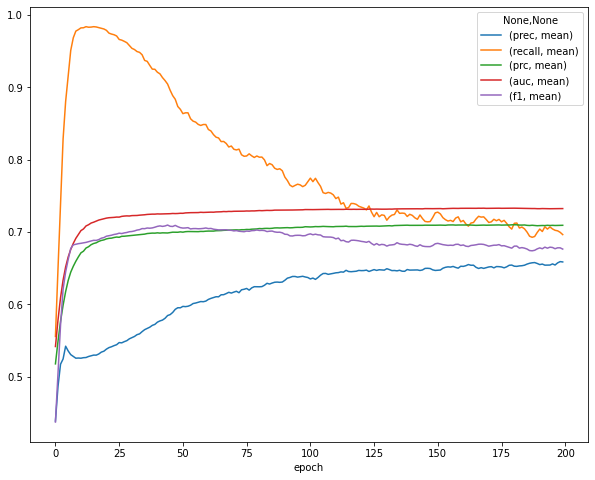




 ===================2 ==============
in shift function: (76462, 2, 11) 623.0 label

===========round: 0, X: (1246,), Y: (1246,) ======
round:  0 kfold:  0 train size:  934 test size:  312
round:  0 kfold:  1 train size:  934 test size:  312
round:  0 kfold:  2 train size:  935 test size:  311
round:  0 kfold:  3 train size:  935 test size:  311

===========round: 1, X: (1246,), Y: (1246,) ======
round:  1 kfold:  0 train size:  934 test size:  312
round:  1 kfold:  1 train size:  934 test size:  312
round:  1 kfold:  2 train size:  935 test size:  311
round:  1 kfold:  3 train size:  935 test size:  311

===========round: 2, X: (1246,), Y: (1246,) ======
round:  2 kfold:  0 train size:  934 test size:  312
round:  2 kfold:  1 train size:  934 test size:  312
round:  2 kfold:  2 train size:  935 test size:  311
round:  2 kfold:  3 train size:  935 test size:  311

===========round: 3, X: (1246,), Y: (1246,) ======
round:  3 kfold:  0 train size:  934 test size:  312
round:  3 kfold: 

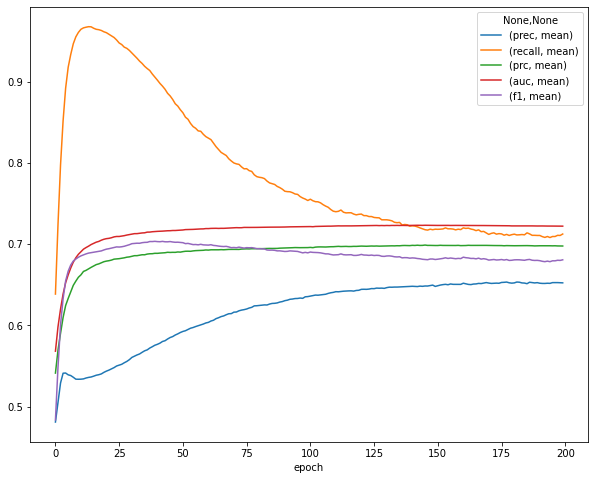




 ===================1 ==============
in shift function: (87765, 1, 11) 720.0 label

===========round: 0, X: (1440,), Y: (1440,) ======
round:  0 kfold:  0 train size:  1080 test size:  360
round:  0 kfold:  1 train size:  1080 test size:  360
round:  0 kfold:  2 train size:  1080 test size:  360
round:  0 kfold:  3 train size:  1080 test size:  360

===========round: 1, X: (1440,), Y: (1440,) ======
round:  1 kfold:  0 train size:  1080 test size:  360
round:  1 kfold:  1 train size:  1080 test size:  360
round:  1 kfold:  2 train size:  1080 test size:  360
round:  1 kfold:  3 train size:  1080 test size:  360

===========round: 2, X: (1440,), Y: (1440,) ======
round:  2 kfold:  0 train size:  1080 test size:  360
round:  2 kfold:  1 train size:  1080 test size:  360
round:  2 kfold:  2 train size:  1080 test size:  360
round:  2 kfold:  3 train size:  1080 test size:  360

===========round: 3, X: (1440,), Y: (1440,) ======
round:  3 kfold:  0 train size:  1080 test size:  360
roun

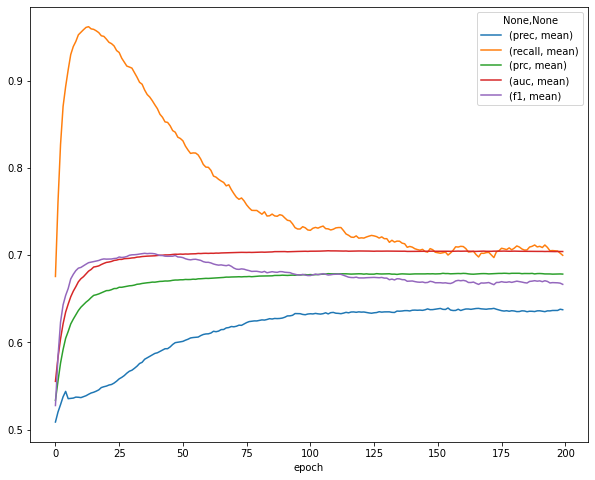

In [58]:
file = "data/final/metrics_granular_merged_bert.pkl"

set_seed()

WORD_CATS = ['WeakModal','Uncertainty', 'Negative', 'Litigious',  \
                 'StrongModal', 'Reward',  'Compare', \
                 'Positive','Discrep','Achieve']

fin_cols = ['ch_rec', 'soft_asset', 'ch_cs', 'ch_roa', 'issue', 
            'asset_turnover', 'rg', 'depi', 'gmi',  'opm', 
            #'ch_inv',   #'aqi', #'sg', #'sgee'
           ]

data = pd.read_pickle(file)
data.columns
key_cols = ["cik", "y1", "y2"]
data = data.sort_values(by = key_cols)
   
total_change_col = "s_max_orig"
target_col = 'label'

word_cols = []

for c in WORD_CATS:
    #word_cols += [c+ "_p", c+ "_n", c+ "_new",c+ "_dis"]
    word_cols += [c+ "_up", c+ "_down", c+ "_add",c+ "_del"]

data = data[key_cols + fin_cols +  word_cols + [total_change_col] + [target_col]]

# only have s_max in fin_cols
fin_cols += [total_change_col]

len(data)
data.head()
data[target_col].sum()

for w in [3,2,1]:

  print(f'\n\n\n ==================={w} ==============')

  hists = repeated_sampling_cv_lstm_only(data, target_col, fin_cols, num_epoch=200, cv =4, name = "model",\
                         rounds = 10, lstm_units = 40, dense_units = 64, \
                         class_weight = None, lr=0.0005, verbose = 0)
  
  results, agg_results = result_analysis(hists)
  results.to_csv("results/wo_word_metrics_bert" + str(w) + ".csv", header= True, index = False)


In [ ]:
# combine resuls from 2 rounds

for w in [3,2,1]:

  print(f'\n\n\n ==================={w} ==============')
  results = pd.read_csv("results/round1/wo_word_metrics" + str(w) + ".csv")
  result1 = pd.read_csv("results/wo_word_metrics" + str(w) + ".csv")
  results = results.append(result1)
  results.to_csv("results/wo_word_metrics_complete_" + str(w) + ".csv", header= True, index = False)
  len(results)

  agg_results = results.groupby(["round","epoch"]).mean().groupby("epoch").agg(
                      {'auc':[np.mean, np.std],
                       'f1':[np.mean, np.std],
                       'prc':[np.mean, np.std],
                       'prec':[np.mean, np.std],
                       'recall':[np.mean, np.std],})
  
  # find best epoch
  print("\n==== Best Epoch =========")
  #cols = [(x, 'mean') for x in ["prec","recall","prc","auc", "f1"]]
  print(agg_results[("auc", "mean")].idxmax())
  print(agg_results.loc[agg_results[("auc", "mean")].idxmax(), [("auc", "mean"),("prc", "mean")]])

#### Baseline: without trajectory

Index(['cik', 'y1', 'y2', 'Achieve_add', 'Achieve_del', 'Achieve_down',
       'Achieve_up', 'Compare_add', 'Compare_del', 'Compare_down',
       'Compare_up', 'Discrep_add', 'Discrep_del', 'Discrep_down',
       'Discrep_up', 'Litigious_add', 'Litigious_del', 'Litigious_down',
       'Litigious_up', 'Negative_add', 'Negative_del', 'Negative_down',
       'Negative_up', 'Positive_add', 'Positive_del', 'Positive_down',
       'Positive_up', 'Reward_add', 'Reward_del', 'Reward_down', 'Reward_up',
       'StrongModal_add', 'StrongModal_del', 'StrongModal_down',
       'StrongModal_up', 'Uncertainty_add', 'Uncertainty_del',
       'Uncertainty_down', 'Uncertainty_up', 'WeakModal_add', 'WeakModal_del',
       'WeakModal_down', 'WeakModal_up', 's_max', 's_max_orig', 's_min',
       'ch_rec', 'soft_asset', 'ch_cs', 'ch_roa', 'issue', 'asset_turnover',
       'rg', 'depi', 'gmi', 'opm', 'label'],
      dtype='object')

87765

,cik,y1,y2,ch_rec,soft_asset,ch_cs,ch_roa,issue,asset_turnover,rg,...,Discrep_up,Discrep_down,Discrep_add,Discrep_del,Achieve_up,Achieve_down,Achieve_add,Achieve_del,s_max_orig,label
0,20,1995,1996,-0.072425,0.661974,-0.208195,0.168310,1.0,1.624273,0.783539,...,0.172414,0.068966,0.000000,0.008677,0.034483,0.275862,0.008547,0.007822,0.689966,0
1,20,1996,1997,-0.018252,0.620435,-0.066028,0.034753,1.0,1.606518,0.938786,...,0.033333,0.133333,0.027778,0.000000,0.100000,0.133333,0.000000,0.000000,0.855465,0
2,20,1997,1998,0.066711,0.656729,-0.030720,0.019574,1.0,1.574474,1.241132,...,0.142857,0.071429,0.009016,0.022117,0.035714,0.357143,0.008147,0.015463,0.567531,0
3,20,1998,1999,0.026323,0.676757,0.011434,0.002424,1.0,1.604656,1.077020,...,0.057143,0.057143,0.014353,0.006807,0.085714,0.114286,0.009770,0.009726,0.738266,0
4,20,1999,2000,-0.024929,0.705573,-0.001713,-0.014429,1.0,1.560280,0.933610,...,0.117647,0.147059,0.000000,0.008065,0.058824,0.029412,0.000000,0.005956,0.788262,0


720




 ===================3 ==============
in shift function: (66511, 3, 10) 538.0 label

===========round: 0, X: (1076,), Y: (1076,) ======
round:  0 kfold:  0 train size:  807 test size:  269
round:  0 kfold:  1 train size:  807 test size:  269
round:  0 kfold:  2 train size:  807 test size:  269
round:  0 kfold:  3 train size:  807 test size:  269

===========round: 1, X: (1076,), Y: (1076,) ======
round:  1 kfold:  0 train size:  807 test size:  269
round:  1 kfold:  1 train size:  807 test size:  269
round:  1 kfold:  2 train size:  807 test size:  269
round:  1 kfold:  3 train size:  807 test size:  269

===========round: 2, X: (1076,), Y: (1076,) ======
round:  2 kfold:  0 train size:  807 test size:  269
round:  2 kfold:  1 train size:  807 test size:  269
round:  2 kfold:  2 train size:  807 test size:  269
round:  2 kfold:  3 train size:  807 test size:  269

===========round: 3, X: (1076,), Y: (1076,) ======
round:  3 kfold:  0 train size:  807 test size:  269
round:  3 kfold: 

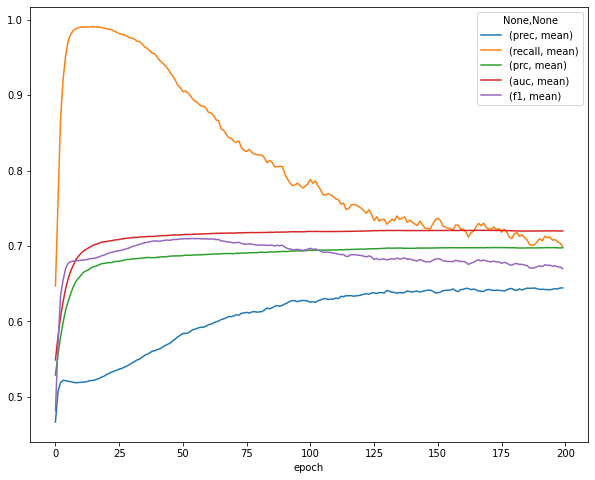




 ===================2 ==============
in shift function: (76462, 2, 10) 623.0 label

===========round: 0, X: (1246,), Y: (1246,) ======
round:  0 kfold:  0 train size:  934 test size:  312
round:  0 kfold:  1 train size:  934 test size:  312
round:  0 kfold:  2 train size:  935 test size:  311
round:  0 kfold:  3 train size:  935 test size:  311

===========round: 1, X: (1246,), Y: (1246,) ======
round:  1 kfold:  0 train size:  934 test size:  312
round:  1 kfold:  1 train size:  934 test size:  312
round:  1 kfold:  2 train size:  935 test size:  311
round:  1 kfold:  3 train size:  935 test size:  311

===========round: 2, X: (1246,), Y: (1246,) ======
round:  2 kfold:  0 train size:  934 test size:  312
round:  2 kfold:  1 train size:  934 test size:  312
round:  2 kfold:  2 train size:  935 test size:  311
round:  2 kfold:  3 train size:  935 test size:  311

===========round: 3, X: (1246,), Y: (1246,) ======
round:  3 kfold:  0 train size:  934 test size:  312
round:  3 kfold: 

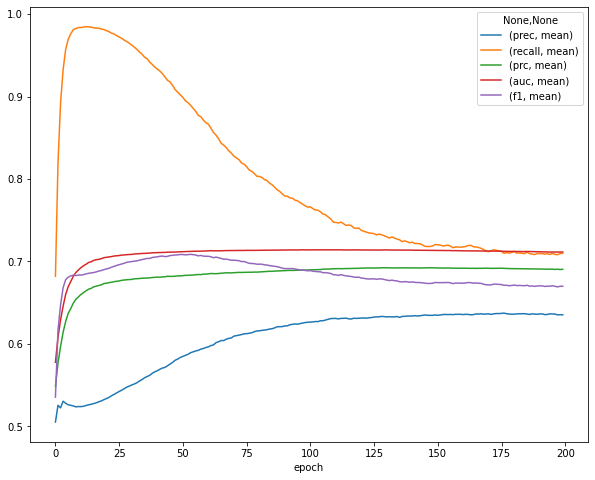




 ===================1 ==============
in shift function: (87765, 1, 10) 720.0 label

===========round: 0, X: (1440,), Y: (1440,) ======
round:  0 kfold:  0 train size:  1080 test size:  360
round:  0 kfold:  1 train size:  1080 test size:  360
round:  0 kfold:  2 train size:  1080 test size:  360
round:  0 kfold:  3 train size:  1080 test size:  360

===========round: 1, X: (1440,), Y: (1440,) ======
round:  1 kfold:  0 train size:  1080 test size:  360
round:  1 kfold:  1 train size:  1080 test size:  360
round:  1 kfold:  2 train size:  1080 test size:  360
round:  1 kfold:  3 train size:  1080 test size:  360

===========round: 2, X: (1440,), Y: (1440,) ======
round:  2 kfold:  0 train size:  1080 test size:  360
round:  2 kfold:  1 train size:  1080 test size:  360
round:  2 kfold:  2 train size:  1080 test size:  360
round:  2 kfold:  3 train size:  1080 test size:  360

===========round: 3, X: (1440,), Y: (1440,) ======
round:  3 kfold:  0 train size:  1080 test size:  360
roun

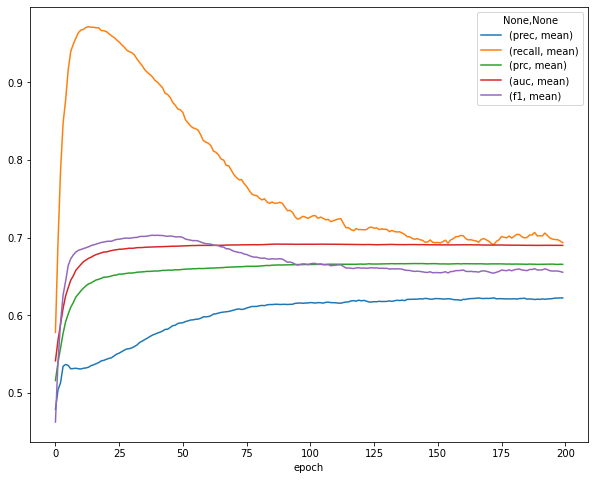

In [59]:
file = "data/final/metrics_granular_merged_bert.pkl"

set_seed()

WORD_CATS = ['WeakModal','Uncertainty', 'Negative', 'Litigious',  \
                 'StrongModal', 'Reward',  'Compare', \
                 'Positive','Discrep','Achieve']

fin_cols = ['ch_rec', 'soft_asset', 'ch_cs', 'ch_roa', 'issue', 
            'asset_turnover', 'rg', 'depi', 'gmi',  'opm', 
            #'ch_inv',   #'aqi', #'sg', #'sgee'
           ]

data = pd.read_pickle(file)
data.columns
key_cols = ["cik", "y1", "y2"]
data = data.sort_values(by = key_cols)
   
total_change_col = "s_max_orig"
target_col = 'label'

word_cols = []

for c in WORD_CATS:
    #word_cols += [c+ "_p", c+ "_n", c+ "_new",c+ "_dis"]
    word_cols += [c+ "_up", c+ "_down", c+ "_add",c+ "_del"]

data = data[key_cols + fin_cols +  word_cols + [total_change_col] + [target_col]]

# only have s_max in fin_cols
#fin_cols += [total_change_col]

len(data)
data.head()
data[target_col].sum()

for w in [3,2,1]:

  print(f'\n\n\n ==================={w} ==============')

  hists = repeated_sampling_cv_lstm_only(data, target_col, fin_cols, num_epoch=200, cv =4, name = "model",\
                         rounds = 15, lstm_units = 40, dense_units = 64, \
                         class_weight = None, lr=0.0005, verbose = 0)
  
  results, agg_results = result_analysis(hists)
  results.to_csv("results/wo_trajectory_bert" + str(w) + ".csv", header= True, index = False)

In [ ]:
for w in [3,2,1]:

  print(f'\n\n\n ==================={w} ==============')
  results = pd.read_csv("results/round1/wo_trajectory" + str(w) + ".csv")
  result1 = pd.read_csv("results/wo_trajectory" + str(w) + ".csv")
  results = results.append(result1)
  results.to_csv("results/wo_trajectory_complete_" + str(w) + ".csv", header= True, index = False)
  len(results)

  agg_results = results.groupby(["round","epoch"]).mean().groupby("epoch").agg(
                      {'auc':[np.mean, np.std],
                       'f1':[np.mean, np.std],
                       'prc':[np.mean, np.std],
                       'prec':[np.mean, np.std],
                       'recall':[np.mean, np.std],})
  
  # find best epoch
  print("\n==== Best Epoch =========")
  #cols = [(x, 'mean') for x in ["prec","recall","prc","auc", "f1"]]
  print(agg_results[("auc", "mean")].idxmax())
  print(agg_results.loc[agg_results[("auc", "mean")].idxmax(), [("auc", "mean"),("prc", "mean")]])

#### Baseline: without TCN

Index(['cik', 'y1', 'y2', 'Achieve_add', 'Achieve_del', 'Achieve_down',
       'Achieve_up', 'Compare_add', 'Compare_del', 'Compare_down',
       'Compare_up', 'Discrep_add', 'Discrep_del', 'Discrep_down',
       'Discrep_up', 'Litigious_add', 'Litigious_del', 'Litigious_down',
       'Litigious_up', 'Negative_add', 'Negative_del', 'Negative_down',
       'Negative_up', 'Positive_add', 'Positive_del', 'Positive_down',
       'Positive_up', 'Reward_add', 'Reward_del', 'Reward_down', 'Reward_up',
       'StrongModal_add', 'StrongModal_del', 'StrongModal_down',
       'StrongModal_up', 'Uncertainty_add', 'Uncertainty_del',
       'Uncertainty_down', 'Uncertainty_up', 'WeakModal_add', 'WeakModal_del',
       'WeakModal_down', 'WeakModal_up', 's_max', 's_max_orig', 's_min',
       'ch_rec', 'soft_asset', 'ch_cs', 'ch_roa', 'issue', 'asset_turnover',
       'rg', 'depi', 'gmi', 'opm', 'label'],
      dtype='object')

87765

,cik,y1,y2,ch_rec,soft_asset,ch_cs,ch_roa,issue,asset_turnover,rg,...,Discrep_up,Discrep_down,Discrep_add,Discrep_del,Achieve_up,Achieve_down,Achieve_add,Achieve_del,s_max_orig,label
0,20,1995,1996,-0.072425,0.661974,-0.208195,0.168310,1.0,1.624273,0.783539,...,0.172414,0.068966,0.000000,0.008677,0.034483,0.275862,0.008547,0.007822,0.689966,0
1,20,1996,1997,-0.018252,0.620435,-0.066028,0.034753,1.0,1.606518,0.938786,...,0.033333,0.133333,0.027778,0.000000,0.100000,0.133333,0.000000,0.000000,0.855465,0
2,20,1997,1998,0.066711,0.656729,-0.030720,0.019574,1.0,1.574474,1.241132,...,0.142857,0.071429,0.009016,0.022117,0.035714,0.357143,0.008147,0.015463,0.567531,0
3,20,1998,1999,0.026323,0.676757,0.011434,0.002424,1.0,1.604656,1.077020,...,0.057143,0.057143,0.014353,0.006807,0.085714,0.114286,0.009770,0.009726,0.738266,0
4,20,1999,2000,-0.024929,0.705573,-0.001713,-0.014429,1.0,1.560280,0.933610,...,0.117647,0.147059,0.000000,0.008065,0.058824,0.029412,0.000000,0.005956,0.788262,0


720




 ===================3 ==============
in shift function: (66511, 3, 51) 538.0 label

===========round: 0, X: (1076,), Y: (1076,) ======
round:  0 kfold:  0 train size:  807 test size:  269
round:  0 kfold:  1 train size:  807 test size:  269
round:  0 kfold:  2 train size:  807 test size:  269
round:  0 kfold:  3 train size:  807 test size:  269

===========round: 1, X: (1076,), Y: (1076,) ======
round:  1 kfold:  0 train size:  807 test size:  269
round:  1 kfold:  1 train size:  807 test size:  269
round:  1 kfold:  2 train size:  807 test size:  269
round:  1 kfold:  3 train size:  807 test size:  269

===========round: 2, X: (1076,), Y: (1076,) ======
round:  2 kfold:  0 train size:  807 test size:  269
round:  2 kfold:  1 train size:  807 test size:  269
round:  2 kfold:  2 train size:  807 test size:  269
round:  2 kfold:  3 train size:  807 test size:  269

===========round: 3, X: (1076,), Y: (1076,) ======
round:  3 kfold:  0 train size:  807 test size:  269
round:  3 kfold: 

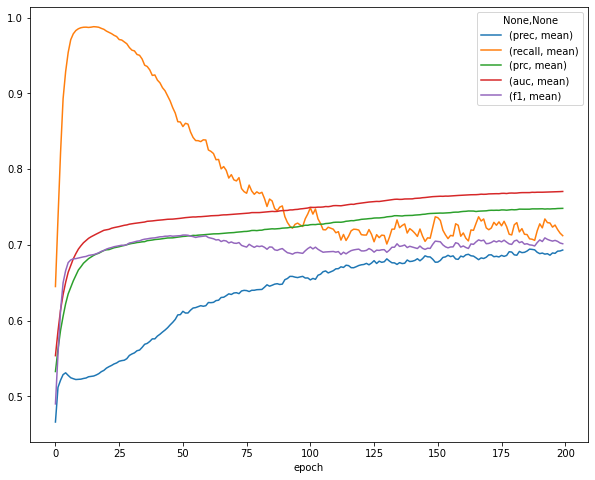




 ===================2 ==============
in shift function: (76462, 2, 51) 623.0 label

===========round: 0, X: (1246,), Y: (1246,) ======
round:  0 kfold:  0 train size:  934 test size:  312
round:  0 kfold:  1 train size:  934 test size:  312
round:  0 kfold:  2 train size:  935 test size:  311
round:  0 kfold:  3 train size:  935 test size:  311

===========round: 1, X: (1246,), Y: (1246,) ======
round:  1 kfold:  0 train size:  934 test size:  312
round:  1 kfold:  1 train size:  934 test size:  312
round:  1 kfold:  2 train size:  935 test size:  311
round:  1 kfold:  3 train size:  935 test size:  311

===========round: 2, X: (1246,), Y: (1246,) ======
round:  2 kfold:  0 train size:  934 test size:  312
round:  2 kfold:  1 train size:  934 test size:  312
round:  2 kfold:  2 train size:  935 test size:  311
round:  2 kfold:  3 train size:  935 test size:  311

===========round: 3, X: (1246,), Y: (1246,) ======
round:  3 kfold:  0 train size:  934 test size:  312
round:  3 kfold: 

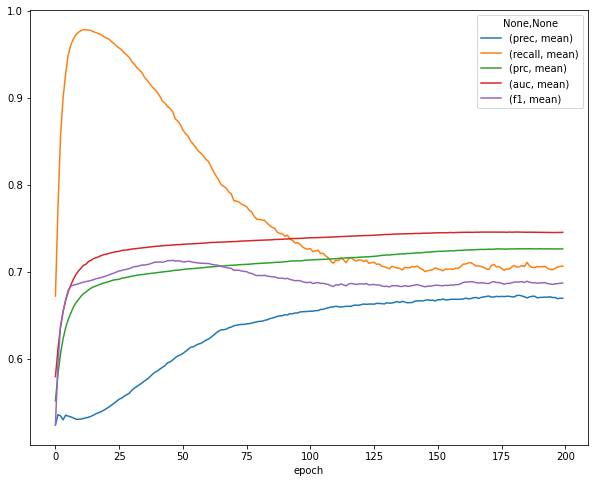




 ===================1 ==============
in shift function: (87765, 1, 51) 720.0 label

===========round: 0, X: (1440,), Y: (1440,) ======
round:  0 kfold:  0 train size:  1080 test size:  360
round:  0 kfold:  1 train size:  1080 test size:  360
round:  0 kfold:  2 train size:  1080 test size:  360
round:  0 kfold:  3 train size:  1080 test size:  360

===========round: 1, X: (1440,), Y: (1440,) ======
round:  1 kfold:  0 train size:  1080 test size:  360
round:  1 kfold:  1 train size:  1080 test size:  360
round:  1 kfold:  2 train size:  1080 test size:  360
round:  1 kfold:  3 train size:  1080 test size:  360

===========round: 2, X: (1440,), Y: (1440,) ======
round:  2 kfold:  0 train size:  1080 test size:  360
round:  2 kfold:  1 train size:  1080 test size:  360
round:  2 kfold:  2 train size:  1080 test size:  360
round:  2 kfold:  3 train size:  1080 test size:  360

===========round: 3, X: (1440,), Y: (1440,) ======
round:  3 kfold:  0 train size:  1080 test size:  360
roun

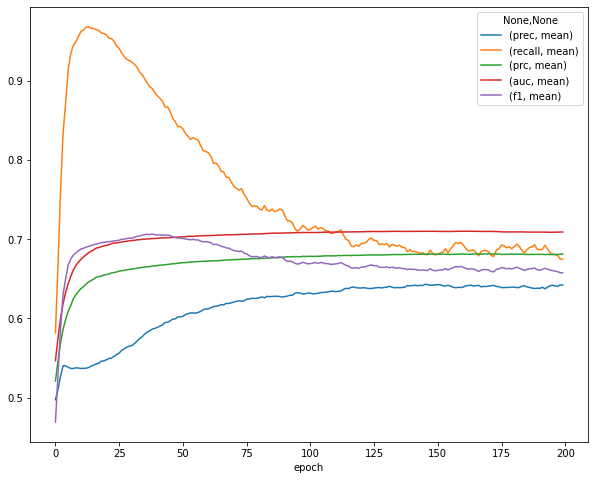

In [60]:
file = "data/final/metrics_granular_merged_bert.pkl"

set_seed()

WORD_CATS = ['WeakModal','Uncertainty', 'Negative', 'Litigious',  \
                 'StrongModal', 'Reward',  'Compare', \
                 'Positive','Discrep','Achieve']

fin_cols = ['ch_rec', 'soft_asset', 'ch_cs', 'ch_roa', 'issue', 
            'asset_turnover', 'rg', 'depi', 'gmi',  'opm', 
            #'ch_inv',   #'aqi', #'sg', #'sgee'
           ]

data = pd.read_pickle(file)
data.columns
key_cols = ["cik", "y1", "y2"]
data = data.sort_values(by = key_cols)
   
total_change_col = "s_max_orig"
target_col = 'label'

word_cols = []

for c in WORD_CATS:
    #word_cols += [c+ "_p", c+ "_n", c+ "_new",c+ "_dis"]
    word_cols += [c+ "_up", c+ "_down", c+ "_add",c+ "_del"]

data = data[key_cols + fin_cols +  word_cols + [total_change_col] + [target_col]]

# put all columns into fin_cols
fin_cols += [total_change_col] 
fin_cols += word_cols

len(data)
data.head()
data[target_col].sum()

for w in [3,2,1]:

  print(f'\n\n\n ==================={w} ==============')

  hists = repeated_sampling_cv_lstm_only(data, target_col, fin_cols, num_epoch=200, cv =4, name = "model",\
                         rounds = 15, lstm_units = 40, dense_units = 64, \
                         class_weight = None, lr=0.0005, verbose = 0)
  
  results, agg_results = result_analysis(hists)
  results.to_csv("results/wo_tcn_bert" + str(w) + ".csv", header= True, index = False)

In [ ]:
for w in [3,2,1]:

  print(f'\n\n\n ==================={w} ==============')
  results = pd.read_csv("results/round1/wo_tcn" + str(w) + ".csv")
  result1 = pd.read_csv("results/wo_tcn" + str(w) + ".csv")
  results = results.append(result1)
  results.to_csv("results/wo_tcn_complete_" + str(w) + ".csv", header= True, index = False)
  len(results)

  agg_results = results.groupby(["round","epoch"]).mean().groupby("epoch").agg(
                      {'auc':[np.mean, np.std],
                       'f1':[np.mean, np.std],
                       'prc':[np.mean, np.std],
                       'prec':[np.mean, np.std],
                       'recall':[np.mean, np.std],})
  
  # find best epoch
  print("\n==== Best Epoch =========")
  #cols = [(x, 'mean') for x in ["prec","recall","prc","auc", "f1"]]
  print(agg_results[("auc", "mean")].idxmax())
  print(agg_results.loc[agg_results[("auc", "mean")].idxmax(), [("auc", "mean"),("prc", "mean")]])

#### Baseline: Unidirectional LSTM

In [ ]:
file = "data/final/metrics_granular_merged.pkl"

set_seed()

WORD_CATS = ['WeakModal','Uncertainty', 'Negative', 'Litigious',  \
                 'StrongModal', 'Reward',  'Compare', \
                 'Positive','Discrep','Achieve']

fin_cols = ['ch_rec', 'soft_asset', 'ch_cs', 'ch_roa', 'issue', 
            'asset_turnover', 'rg', 'depi', 'gmi',  'opm', 
            #'ch_inv',   #'aqi', #'sg', #'sgee'
           ]

data = pd.read_pickle(file)
data.columns
key_cols = ["cik", "y1", "y2"]
data = data.sort_values(by = key_cols)
   
total_change_col = "s_max_orig"
target_col = 'label'

word_cols = []

for c in WORD_CATS:
    #word_cols += [c+ "_p", c+ "_n", c+ "_new",c+ "_dis"]
    word_cols += [c+ "_up", c+ "_down", c+ "_add",c+ "_del"]

data = data[key_cols + fin_cols +  word_cols + [total_change_col] + [target_col]]

# put all columns into fin_cols
fin_cols += [total_change_col] 
fin_cols += word_cols

len(data)
data.head()
data[target_col].sum()

for w in [3,2,1]:
  class_weight ={0:1, 1:100}
  print(f'\n\n\n ==================={w} ==============')

  hists = cross_validate_lstm_only(data, target_col, fin_cols, num_epoch=200, cv =4, name = "model",\
                         lstm_units = 40, dense_units = 64, bidirectional = False, \
                         class_weight = class_weight, lr=0.0005, verbose = 0)
  
  results, agg_results = result_analysis(hists)
  results.to_csv("results/unidirection_lstm_no_sampling" + str(w) + ".csv", header= True, index = False)

# Result analysis

In [81]:
def do_analysis(results, plot = True):
  agg_results = results.groupby(["round","epoch"]).mean().groupby("epoch").agg(
                      {'auc':[np.mean, np.std],
                       'f1':[np.mean, np.std],
                       'prc':[np.mean, np.std],
                       'prec':[np.mean, np.std],
                       'recall':[np.mean, np.std],})

  if plot:
      #print("\n==== Aggregated Metrics =========")
      #print(agg_results.head())
  
    
      # find best epoch
      print("\n==== Best Epoch =========")
      cols = [(x, 'mean') for x in ["prec","recall","prc","auc", "f1"]]
      print(agg_results[cols].idxmax())
      print(agg_results[cols].iloc[agg_results[cols].idxmax()])
    
      print("\n==== Epoch 200=========")
      print(agg_results[cols].loc[199])

      # plot metrics vs. epochs
      #print("\n==== Plot =========")
      #agg_results[cols].plot(kind = 'line', figsize=(10,8))
      #plt.show()
    
  #return agg_results, agg_results[("auc", 'mean')].idxmax()
  return agg_results, 199
   
  

## Cross Validation

### Matched

In [ ]:
s = '60_40'

for w in [3,2,1]:

    print(f'\n\n\n ==================={w} ==============')
    #df = pd.read_csv("results/round1/granular_"+s +"_"+ str(w) + '.csv')
    #df1 = pd.read_csv("results/granular_"+s +"_"+ str(w) + '.csv')
    #df = df.append(df1)
    #len(df)
    #df.to_csv("results/granular_complete_"+s +"_"+ str(w) + '.csv')
    df =pd.read_csv("results/granular_complete_"+s +"_"+ str(w) + '.csv')
    agg_result,epoch = do_analysis(df)
    epoch

### Unmatched

In [ ]:
s = '60_40'

for w in [3,2,1]:

    print(f'\n\n\n ==================={w} ==============')
    df = pd.read_csv("results/round1/unmatch_"+s +"_"+ str(w) + '.csv')
    df1 = pd.read_csv("results/unmatch_"+s +"_"+ str(w) + '.csv')
    df = df.append(df1)
    len(df)
    df.to_csv("results/unmatch_complete_"+s +"_"+ str(w) + '.csv')
    do_analysis(df)



## Out of Sample

### Granular change

In [40]:
s = '60_40'

# df = pd.read_csv("results/round1/granular_out_of_sample_clean" + s + ".csv")
# len(df)
# df1 = pd.read_csv("results/granular_out_of_sample_" + s + ".csv")
# len(df1)
# df = df.append(df1)
# len(df)
# df.to_csv("results/granular_out_of_sample_complete_" + s + ".csv", header=True, index=False)
df = pd.read_csv("results/TFIDF/Sampling/granular_out_of_sample_complete_" + s + ".csv")
df.head()
agg_results = df.groupby(["year","epoch"]).agg(
                      {'auc':[np.mean, np.std],
                       'f1':[np.mean, np.std],
                       'prc':[np.mean, np.std],
                       'prec':[np.mean, np.std],
                       'recall':[np.mean, np.std]})
#cols = [(x, 'mean') for x in ["prec","recall","prc","auc", "f1"]]

#idx = agg_results.groupby("year")[cols].idxmax()
#agg_results.groupby("year").apply(lambda d: d.loc[d[cols].idxmax(), cols])

cols = [("auc", 'mean')]
idx = agg_results.groupby("year")[cols].idxmax()
print(idx)
#agg_results.groupby("year").apply(lambda d: d.loc[d[cols].idxmax(), cols])
#agg_results.groupby("year").apply(lambda d: d.loc[d[cols].idxmax(), cols]).mean()

cols = [("prc", 'mean')]
#idx = agg_results.groupby("year")[cols].idxmax()
agg_results.groupby("year").apply(lambda d: d.loc[d[cols].idxmax(), cols])
agg_results.groupby("year").apply(lambda d: d.loc[d[cols].idxmax(), cols]).mean()

cols = [("prec", 'mean')]
#idx = agg_results.groupby("year")[cols].idxmax()
agg_results.groupby("year").apply(lambda d: d.loc[d[cols].idxmax(), cols])
agg_results.groupby("year").apply(lambda d: d.loc[d[cols].idxmax(), cols]).mean()

cols = [("recall", 'mean')]
#idx = agg_results.groupby("year")[cols].idxmax()
agg_results.groupby("year").apply(lambda d: d.loc[d[cols].idxmax(), cols])
agg_results.groupby("year").apply(lambda d: d.loc[d[cols].idxmax(), cols]).mean()

,Unnamed: 0,round,fold,prec,recall,prc,auc,f1,epoch,year
0,0.0,0,0,0.501319,1.0,0.510477,0.563643,0.667838,0.0,2005
1,1.0,0,0,0.500000,1.0,0.555393,0.615755,0.666667,1.0,2005
2,2.0,0,0,0.500000,1.0,0.586899,0.652078,0.666667,2.0,2005
3,3.0,0,0,0.500000,1.0,0.599862,0.671295,0.666667,3.0,2005
4,4.0,0,0,0.501319,1.0,0.617623,0.687119,0.667838,4.0,2005


                auc
               mean
year               
2005  (2005, 199.0)
2006  (2006, 199.0)
2007  (2007, 195.0)
2008  (2008, 199.0)
2009  (2009, 199.0)
2010  (2010, 197.0)
2011  (2011, 199.0)
2012  (2012, 172.0)
2013  (2013, 192.0)


,,,auc
,,,mean
year,year,epoch,
2005,2005,199.0,0.750648
2006,2006,199.0,0.752548
2007,2007,195.0,0.776226
2008,2008,199.0,0.792669
2009,2009,199.0,0.665053
2010,2010,197.0,0.621588
2011,2011,199.0,0.731482
2012,2012,172.0,0.805549


auc  mean    0.743765
dtype: float64

,,,prc
,,,mean
year,year,epoch,
2005,2005,199.0,0.705184
2006,2006,196.0,0.729662
2007,2007,196.0,0.736983
2008,2008,199.0,0.755792
2009,2009,199.0,0.652042
2010,2010,22.0,0.624999
2011,2011,198.0,0.677498
2012,2012,199.0,0.769577


prc  mean    0.711205
dtype: float64

,,,prec
,,,mean
year,year,epoch,
2005,2005,198.0,0.681729
2006,2006,195.0,0.682229
2007,2007,196.0,0.700876
2008,2008,199.0,0.725951
2009,2009,195.0,0.651559
2010,2010,86.0,0.691456
2011,2011,79.0,0.706193
2012,2012,144.0,0.764121


prec  mean    0.705733
dtype: float64

,,,recall
,,,mean
year,year,epoch,
2005,2005,15.0,0.975000
2006,2006,13.0,0.942083
2007,2007,11.0,0.955000
2008,2008,15.0,0.973846
2009,2009,10.0,0.936923
2010,2010,10.0,0.886111
2011,2011,10.0,0.921333
2012,2012,12.0,0.964286


recall  mean    0.949329
dtype: float64

In [43]:
s = '60_40'

# df = pd.read_csv("results/round1/granular_out_of_sample_clean" + s + ".csv")
# len(df)
# df1 = pd.read_csv("results/granular_out_of_sample_" + s + ".csv")
# len(df1)
# df = df.append(df1)
# len(df)
# df.to_csv("results/granular_out_of_sample_complete_" + s + ".csv", header=True, index=False)
df = pd.read_csv("results/TFIDF/Sampling/granular_out_of_sample_complete_" + s + ".csv")

agg_results = df.groupby(["year","epoch"]).agg(
                      {'auc':[np.mean, np.std],
                       'f1':[np.mean, np.std],
                       'prc':[np.mean, np.std],
                       'prec':[np.mean, np.std],
                       'recall':[np.mean, np.std]})

agg_results.xs(199, level='epoch')

auc                  f1                 prc                prec  \
          mean       std      mean       std      mean       std      mean   
year                                                                         
2005  0.750648  0.026402  0.673317  0.062536  0.705184  0.031551  0.680977   
2006  0.752548  0.030441  0.679110  0.061521  0.727878  0.034127  0.676827   
2007  0.775285  0.031936  0.678842  0.072071  0.734675  0.038055  0.693282   
2008  0.792669  0.033555  0.707251  0.075437  0.755792  0.040983  0.725951   
2009  0.665053  0.048300  0.511176  0.111409  0.652042  0.044578  0.647852   
2010  0.620961  0.035154  0.429464  0.100925  0.607632  0.041080  0.622534   
2011  0.731482  0.035994  0.561669  0.102393  0.676659  0.039366  0.697140   
2012  0.805107  0.030123  0.674965  0.089208  0.769577  0.038193  0.754536   
2013  0.797627  0.036049  0.653989  0.123983  0.747964  0.044905  0.738208   

                  recall            
           std      mean       std  
year                                
2005  0.033581  0.681053  0.126912  
2006  0.055022  0.704167  0.137557  
2007  0.044329  0.684545  0.142401  
2008  0.051141  0.703846  0.131825  
2009  0.060741  0.440000  0.145492  
2010  0.061770  0.341111  0.114161  
2011  0.061736  0.485333  0.132685  
2012  0.049118  0.630000  0.146398  
2013  0.068750  0.625000  0.199035

In [ ]:
cols = [("auc", 'mean')]
t = agg_results.groupby("year").apply(lambda d: d.loc[d[cols].idxmax(), [("auc", 'mean'),("prc", 'mean')]])
t
t.iloc[2:].mean()

### Unmatched

In [ ]:
s = '60_40'

df = pd.read_csv("results/round1/unmatch_out_of_sample_clean" + s + ".csv")
len(df)
df1 = pd.read_csv("results/unmatch_out_of_sample_" + s + ".csv")
len(df1)
df = df.append(df1)
len(df)
df.to_csv("results/unmatch_out_of_sample_complete_" + s + ".csv", header=True, index=False)
df.head()

agg_results = df.groupby(["year","epoch"]).agg(
                      {'auc':[np.mean, np.std],
                       'f1':[np.mean, np.std],
                       'prc':[np.mean, np.std],
                       'prec':[np.mean, np.std],
                       'recall':[np.mean, np.std]})
#cols = [(x, 'mean') for x in ["prec","recall","prc","auc", "f1"]]

#idx = agg_results.groupby("year")[cols].idxmax()
#agg_results.groupby("year").apply(lambda d: d.loc[d[cols].idxmax(), cols])

cols = [("auc", 'mean')]
idx = agg_results.groupby("year")[cols].idxmax()
print(idx)
agg_results.groupby("year").apply(lambda d: d.loc[d[cols].idxmax(), cols])
agg_results.groupby("year").apply(lambda d: d.loc[d[cols].idxmax(), cols]).mean()

cols = [("prc", 'mean')]
idx = agg_results.groupby("year")[cols].idxmax()
agg_results.groupby("year").apply(lambda d: d.loc[d[cols].idxmax(), cols])
agg_results.groupby("year").apply(lambda d: d.loc[d[cols].idxmax(), cols]).mean()

In [ ]:
## cols = [("auc", 'mean')]
t = agg_results.groupby("year").apply(lambda d: d.loc[d[cols].idxmax(), [("auc", 'mean'),("prc", 'mean')]])
t
t.iloc[2:].mean()

In [46]:
s = '60_40'

# df = pd.read_csv("results/round1/granular_out_of_sample_clean" + s + ".csv")
# len(df)
# df1 = pd.read_csv("results/granular_out_of_sample_" + s + ".csv")
# len(df1)
# df = df.append(df1)
# len(df)
# df.to_csv("results/granular_out_of_sample_complete_" + s + ".csv", header=True, index=False)
df = pd.read_csv("results/TFIDF/Sampling/unmatch_out_of_sample_complete_" + s + ".csv")

agg_results = df.groupby(["year","epoch"]).agg(
                      {'auc':[np.mean, np.std],
                       'f1':[np.mean, np.std],
                       'prc':[np.mean, np.std],
                       'prec':[np.mean, np.std],
                       'recall':[np.mean, np.std]})

# cols = [("auc", 'mean')]
# idx = agg_results.groupby("year")[cols].idxmax()
# print(idx)

agg_results.xs(199, level='epoch')

auc                  f1                 prc                prec  \
          mean       std      mean       std      mean       std      mean   
year                                                                         
2005  0.719371  0.022326  0.612653  0.079075  0.680110  0.030488  0.681999   
2006  0.708365  0.029839  0.602269  0.107568  0.661237  0.037866  0.649975   
2007  0.753813  0.030847  0.621788  0.094952  0.708119  0.038385  0.686925   
2008  0.683317  0.039909  0.492540  0.146233  0.620100  0.048963  0.631922   
2009  0.561083  0.050551  0.281883  0.153316  0.532709  0.042403  0.479805   
2010  0.625517  0.032640  0.289967  0.128938  0.583410  0.031292  0.553521   
2011  0.686178  0.042529  0.410543  0.151495  0.630402  0.046813  0.655856   
2012  0.733889  0.034542  0.467067  0.145686  0.659065  0.038295  0.681438   
2013  0.702725  0.038144  0.484716  0.163045  0.635451  0.041526  0.634624   

                  recall            
           std      mean       std  
year                                
2005  0.032851  0.570526  0.124329  
2006  0.045530  0.592917  0.185382  
2007  0.042835  0.590000  0.156393  
2008  0.075257  0.426154  0.181118  
2009  0.200337  0.209231  0.130781  
2010  0.118912  0.210000  0.123491  
2011  0.100046  0.318667  0.155000  
2012  0.095931  0.374286  0.160312  
2013  0.093623  0.426875  0.213026

# HCV2, Sampling, Cross Validation

In [ ]:
S = [1,2,3]

for s in S:
    print("\n", s)
    df = pd.read_csv("results/TFIDF/granular_hcv_" + str(s) + ".csv")
    print(df.head())

    agg_results = df.groupby("round").mean()
    print(agg_results[["auc","prc","prec","recall","f1"]].describe()*100)
    


# Mann Whitney U Test

## Ours vs. Modification Score

In [ ]:
s = '64_40'

for w in [3,2,1]:
    print(f"\n==================={w}==============")
    ours = pd.read_csv("results/BERT/granular_BERT_"+s +"_"+ str(w) + '.csv')    
    _, epoch = do_analysis(ours, plot = False)     
    ours = ours[ours.epoch == epoch]
    len(ours)
    
    modi = pd.read_csv("results/unmatch_complete_"+s +"_"+ str(w) + '.csv')
    _, epoch = do_analysis(modi, plot = False)   
    modi = modi[modi.epoch == epoch]
    len(modi)
    
    print(f"AUC")
    res = mannwhitneyu(ours["auc"], modi["auc"], alternative="greater")
    res
    
    print(f"PRC")
    res = mannwhitneyu(ours["prc"], modi["prc"], alternative="greater")
    res


===================3==============


NameError: name 'do_analysis' is not defined

## With or without TCN

In [ ]:
s = '60_40'

for w in [3,2,1]:
    print(f"\n==================={w}==============")
    ours = pd.read_csv("results/granular_complete_"+s +"_"+ str(w) + '.csv')    
    _, epoch = do_analysis(ours, plot = False)     
    ours = ours[ours.epoch == epoch]
    len(ours)
    
    modi = pd.read_csv("results/ablation/wo_tcn_complete_"+ str(w) + '.csv')
    _, epoch = do_analysis(modi, plot = False)   
    modi = modi[modi.epoch == epoch]
    len(modi)
    
    print(f"AUC")
    res = mannwhitneyu(ours["auc"], modi["auc"], alternative="greater")
    res
    
    print(f"PRC")
    res = mannwhitneyu(ours["prc"], modi["prc"], alternative="greater")
    res

# Get all Metrics in one table

## TFIDF Sampling

In [36]:
folder = 'results/TFIDF/Sampling/'
table = []

name = '0. HCV2'

for w in [3,2,1]:
    #print("\n", s)
    df = pd.read_csv(folder + "granular_hcv_" + str(w) + ".csv")
    #print(df.head())

    agg_results = df.groupby("round").mean()
    values = agg_results[["auc","prc","prec","recall","f1"]].mean().values.tolist()
    table.append([name,w] + values)



name = '1. LSTM'

for w in [3,2,1]:

    print(f'\n\n\n ==================={name}, {w} ==============')
    df = pd.read_csv((folder + "unidirection_sampling_lstm_"+ str(w) + '.csv'))
    agg_results, best =do_analysis(df)

    print(best)
    print(agg_results.loc[best])
    table.append([name, w,
                  agg_results.loc[best]['auc']['mean'],
                  agg_results.loc[best]['prc']['mean'],
                  agg_results.loc[best]['prec']['mean'],
                  agg_results.loc[best]['recall']['mean'],
                  agg_results.loc[best]['f1']['mean']])

name = 'E. Deep Learning (Ours)'
s = '60_40'

for w in [3,2,1]:

    print(f'\n\n\n ==================={name}, {w} ==============')
    df = pd.read_csv(folder + "granular_complete_"+s +"_"+ str(w) + '.csv')
    agg_results, best =do_analysis(df)

    print(best)
    print(agg_results.loc[best])
    table.append([name, w, 
                  agg_results.loc[best]['auc']['mean'],
                  agg_results.loc[best]['prc']['mean'],
                  agg_results.loc[best]['prec']['mean'],
                  agg_results.loc[best]['recall']['mean'],
                  agg_results.loc[best]['f1']['mean']])
    
    

name = 'I. Modification Score'


s = '60_40'

for w in [3,2,1]:

    print(f'\n\n\n ==================={name}, {w} ==============')
    df = pd.read_csv((folder + "unmatch_complete_"+s +"_"+ str(w) + '.csv'))
    agg_results, best =do_analysis(df)

    print(best)
    print(agg_results.loc[best])
    table.append([name, w,
                  agg_results.loc[best]['auc']['mean'],
                  agg_results.loc[best]['prc']['mean'],
                  agg_results.loc[best]['prec']['mean'],
                  agg_results.loc[best]['recall']['mean'],
                  agg_results.loc[best]['f1']['mean']])
     
name = 'F. Change Trajectory only'


s = '60_40'

for w in [3,2,1]:

    print(f'\n\n\n ==================={name}, {w} ==============')
    df = pd.read_csv((folder + "ablation/trajectory_only_complete_"+ str(w) + '.csv'))
    agg_results, best =do_analysis(df)

    print(best)
    print(agg_results.loc[best])
    table.append([name, w,
                  agg_results.loc[best]['auc']['mean'],
                  agg_results.loc[best]['prc']['mean'],
                  agg_results.loc[best]['prec']['mean'],
                  agg_results.loc[best]['recall']['mean'],
                  agg_results.loc[best]['f1']['mean']])
    
name = 'G. Fin. Ratios only'


s = '60_40'

for w in [3,2,1]:

    print(f'\n\n\n ==================={name}, {w} ==============')
    df = pd.read_csv((folder + "ablation/wo_trajectory_complete_"+ str(w) + '.csv'))
    agg_results, best =do_analysis(df)

    print(best)
    print(agg_results.loc[best])
    table.append([name, w,
                  agg_results.loc[best]['auc']['mean'],
                  agg_results.loc[best]['prc']['mean'],
                  agg_results.loc[best]['prec']['mean'],
                  agg_results.loc[best]['recall']['mean'],
                  agg_results.loc[best]['f1']['mean']])

name = 'H. Fin. Ratios + Overall Sim.'


s = '60_40'

for w in [3,2,1]:

    print(f'\n\n\n ==================={name}, {w} ==============')
    df = pd.read_csv((folder + "ablation/wo_word_metrics_complete_"+ str(w) + '.csv'))
    agg_results, best =do_analysis(df)

    print(best)
    print(agg_results.loc[best])
    table.append([name, w,
                  agg_results.loc[best]['auc']['mean'],
                  agg_results.loc[best]['prc']['mean'],
                  agg_results.loc[best]['prec']['mean'],
                  agg_results.loc[best]['recall']['mean'],
                  agg_results.loc[best]['f1']['mean']])

name = 'J. W/O TCN'


s = '60_40'

for w in [3,2,1]:

    print(f'\n\n\n ==================={name}, {w} ==============')
    df = pd.read_csv((folder + "ablation/wo_tcn_complete_"+ str(w) + '.csv'))
    agg_results, best =do_analysis(df)

    print(best)
    print(agg_results.loc[best])
    table.append([name, w,
                  agg_results.loc[best]['auc']['mean'],
                  agg_results.loc[best]['prc']['mean'],
                  agg_results.loc[best]['prec']['mean'],
                  agg_results.loc[best]['recall']['mean'],
                  agg_results.loc[best]['f1']['mean']])
        
# H. Fin. Ratios +       Overall Sim.
# I. Modification Score
# J. W/O  TCN
# G. Fin. Ratios only




 ===================1. LSTM, 3 ==============

==== Best Epoch =========
prec    mean    187.0
recall  mean     17.0
prc     mean    199.0
auc     mean    199.0
f1      mean     52.0
dtype: float64
           prec    recall       prc       auc        f1
           mean      mean      mean      mean      mean
epoch                                                  
187.0  0.688920  0.707446  0.739859  0.762320  0.697233
17.0   0.527961  0.982156  0.679000  0.703868  0.686160
199.0  0.687770  0.711165  0.740800  0.763645  0.698530
199.0  0.687770  0.711165  0.740800  0.763645  0.698530
52.0   0.601942  0.862977  0.706518  0.730050  0.708554

==== Epoch 200=========
prec    mean    0.687770
recall  mean    0.711165
prc     mean    0.740800
auc     mean    0.763645
f1      mean    0.698530
Name: 199.0, dtype: float64
199.0
auc     mean    0.763645
        std     0.013142
f1      mean    0.698530
        std     0.010140
prc     mean    0.740800
        std     0.017955
prec    mean    0

In [ ]:
table = pd.DataFrame(table, columns = ['name','window','auc','prc','prec','recall','f1'])
table.head()

In [ ]:
table.groupby(['name','window'])[['auc','prc','prec','recall','f1']].mean().unstack(level = -1)

## BERT Embedding, Sampling

In [127]:
folder = 'results/BERT/Sampling/'
table = []

name = '0. HCV2'

for w in [3,2,1]:
    #print("\n", s)
    df = pd.read_csv(folder + "granular_bert_hcv_" + str(w) + ".csv")
    #print(df.head())

    agg_results = df.groupby("round").mean()
    values = agg_results[["auc","prc","prec","recall","f1"]].mean().values.tolist()
    table.append([name,w] + values)



name = '1. LSTM'

for w in [3,2,1]:

    print(f'\n\n\n ==================={name}, {w} ==============')
    df = pd.read_csv((folder + "uni_lstm_bert_sampling_"+ str(w) + '.csv'))
    agg_results, best =do_analysis(df)

    print(best)
    print(agg_results.loc[best])
    table.append([name, w,
                  agg_results.loc[best]['auc']['mean'],
                  agg_results.loc[best]['prc']['mean'],
                  agg_results.loc[best]['prec']['mean'],
                  agg_results.loc[best]['recall']['mean'],
                  agg_results.loc[best]['f1']['mean']])

name = 'E. Deep Learning (Ours)'
s = '64_40'

for w in [3,2,1]:

    print(f'\n\n\n ==================={name}, {w} ==============')
    df = pd.read_csv(folder + "ours_bert" +"__"+ str(w) + '.csv')
    agg_results, best =do_analysis(df)

    print(best)
    print(agg_results.loc[best])
    table.append([name, w, 
                  agg_results.loc[best]['auc']['mean'],
                  agg_results.loc[best]['prc']['mean'],
                  agg_results.loc[best]['prec']['mean'],
                  agg_results.loc[best]['recall']['mean'],
                  agg_results.loc[best]['f1']['mean']])
    
    

name = 'I. Modification Score'


s = '60_40'

for w in [3,2,1]:

    print(f'\n\n\n ==================={name}, {w} ==============')
    df = pd.read_csv(( "results/TFIDF/Sampling/unmatch_complete_"+s +"_"+ str(w) + '.csv'))
    agg_results, best =do_analysis(df)

    print(best)
    print(agg_results.loc[best])
    table.append([name, w,
                  agg_results.loc[best]['auc']['mean'],
                  agg_results.loc[best]['prc']['mean'],
                  agg_results.loc[best]['prec']['mean'],
                  agg_results.loc[best]['recall']['mean'],
                  agg_results.loc[best]['f1']['mean']])
     
name = 'F. Change Trajectory only'


s = '60_40'

for w in [3,2,1]:

    print(f'\n\n\n ==================={name}, {w} ==============')
    df = pd.read_csv((folder + "trajectory_only_bert__"+ str(w) + '.csv'))
    agg_results, best =do_analysis(df)

    print(best)
    print(agg_results.loc[best])
    #print(150, agg_results.loc[150])
    
    best = 196
    table.append([name, w,
                  agg_results.loc[best]['auc']['mean'],
                  agg_results.loc[best]['prc']['mean'],
                  agg_results.loc[best]['prec']['mean'],
                  agg_results.loc[best]['recall']['mean'],
                  agg_results.loc[best]['f1']['mean']])
    
name = 'G. Fin. Ratios only'


s = '60_40'

for w in [3,2,1]:

    print(f'\n\n\n ==================={name}, {w} ==============')
    df = pd.read_csv((folder +"wo_trajectory_bert"+ str(w) + '.csv'))
    agg_results, best =do_analysis(df)

    print(best)
    print(agg_results.loc[best])
    table.append([name, w,
                  agg_results.loc[best]['auc']['mean'],
                  agg_results.loc[best]['prc']['mean'],
                  agg_results.loc[best]['prec']['mean'],
                  agg_results.loc[best]['recall']['mean'],
                  agg_results.loc[best]['f1']['mean']])

name = 'H. Fin. Ratios + Overall Sim.'


for w in [3,2,1]:

    print(f'\n\n\n ==================={name}, {w} ==============')
    df = pd.read_csv((folder + "wo_word_metrics_bert"+ str(w) + '.csv'))
    agg_results, best =do_analysis(df)

    print(best)
    print(agg_results.loc[best])
    table.append([name, w,
                  agg_results.loc[best]['auc']['mean'],
                  agg_results.loc[best]['prc']['mean'],
                  agg_results.loc[best]['prec']['mean'],
                  agg_results.loc[best]['recall']['mean'],
                  agg_results.loc[best]['f1']['mean']])

name = 'J. W/O TCN'


for w in [3,2,1]:

    print(f'\n\n\n ==================={name}, {w} ==============')
    df = pd.read_csv((folder + "wo_tcn_bert"+ str(w) + '.csv'))
    agg_results, best =do_analysis(df)

    print(best)
    print(agg_results.loc[best])
    table.append([name, w,
                  agg_results.loc[best]['auc']['mean'],
                  agg_results.loc[best]['prc']['mean'],
                  agg_results.loc[best]['prec']['mean'],
                  agg_results.loc[best]['recall']['mean'],
                  agg_results.loc[best]['f1']['mean']])
    
    
        
# H. Fin. Ratios +       Overall Sim.
# I. Modification Score
# J. W/O  TCN
# G. Fin. Ratios only




 ===================1. LSTM, 3 ==============

==== Best Epoch =========
prec    mean    186.0
recall  mean     16.0
prc     mean    197.0
auc     mean    199.0
f1      mean     45.0
dtype: float64
           prec    recall       prc       auc        f1
           mean      mean      mean      mean      mean
epoch                                                  
186.0  0.688439  0.708113  0.743339  0.764433  0.697265
16.0   0.527313  0.981399  0.673474  0.699802  0.684930
197.0  0.685628  0.717784  0.744635  0.765654  0.700541
199.0  0.687846  0.711761  0.744415  0.765705  0.698708
45.0   0.589459  0.897030  0.706568  0.729600  0.710851

==== Epoch 200=========
prec    mean    0.687846
recall  mean    0.711761
prc     mean    0.744415
auc     mean    0.765705
f1      mean    0.698708
Name: 199.0, dtype: float64
199
auc     mean    0.765705
        std     0.012186
f1      mean    0.698708
        std     0.011532
prc     mean    0.744415
        std     0.018524
prec    mean    0.6

In [128]:
table = pd.DataFrame(table, columns = ['name','window','auc','prc','prec','recall','f1'])
table.head()

,name,window,auc,prc,prec,recall,f1
0,0. HCV2,3,0.696623,0.667077,0.641513,0.675858,0.657396
1,0. HCV2,2,0.690135,0.659193,0.640059,0.673042,0.655628
2,0. HCV2,1,0.692113,0.664293,0.637166,0.680944,0.657847
3,1. LSTM,3,0.765705,0.744415,0.687846,0.711761,0.698708
4,1. LSTM,2,0.745368,0.723331,0.669059,0.709864,0.688340


In [129]:
table.groupby(['name','window'])[['auc','prc','prec','recall','f1']].mean().unstack(level = -1)

auc                           prc  \
window                                1         2         3         1   
name                                                                    
0. HCV2                        0.692113  0.690135  0.696623  0.664293   
1. LSTM                        0.715717  0.745368  0.765705  0.686397   
E. Deep Learning (Ours)        0.694918  0.754329  0.798412  0.670618   
F. Change Trajectory only      0.589536  0.694737  0.732668  0.580916   
G. Fin. Ratios only            0.690218  0.711313  0.719960  0.665738   
H. Fin. Ratios + Overall Sim.  0.704171  0.722199  0.732456  0.678296   
I. Modification Score          0.708886  0.748174  0.773859  0.685992   
J. W/O TCN                     0.709151  0.745610  0.770518  0.681383   

                                                       prec            \
window                                2         3         1         2   
name                                                                    
0. HCV2                        0.659193  0.667077  0.637166  0.640059   
1. LSTM                        0.723331  0.744415  0.646225  0.669059   
E. Deep Learning (Ours)        0.732882  0.775143  0.636495  0.669287   
F. Change Trajectory only      0.680329  0.715225  0.571199  0.627430   
G. Fin. Ratios only            0.690405  0.697669  0.622505  0.635126   
H. Fin. Ratios + Overall Sim.  0.697751  0.709346  0.637446  0.652393   
I. Modification Score          0.720097  0.749632  0.633118  0.679361   
J. W/O TCN                     0.726582  0.748219  0.642137  0.669823   

                                           recall                      \
window                                3         1         2         3   
name                                                                    
0. HCV2                        0.641513  0.680944  0.673042  0.675858   
1. LSTM                        0.687846  0.681167  0.709864  0.711761   
E. Deep Learning (Ours)        0.714339  0.680556  0.730918  0.724829   
F. Change Trajectory only      0.662983  0.533056  0.690538  0.704206   
G. Fin. Ratios only            0.644522  0.693704  0.709795  0.698914   
H. Fin. Ratios + Overall Sim.  0.658657  0.699861  0.712513  0.696483   
I. Modification Score          0.708124  0.709167  0.682686  0.681308   
J. W/O TCN                     0.693202  0.675093  0.706901  0.712183   

                                     f1                      
window                                1         2         3  
name                                                         
0. HCV2                        0.657847  0.655628  0.657396  
1. LSTM                        0.662723  0.688340  0.698708  
E. Deep Learning (Ours)        0.655778  0.696421  0.714857  
F. Change Trajectory only      0.549605  0.653815  0.676214  
G. Fin. Ratios only            0.655562  0.669855  0.670035  
H. Fin. Ratios + Overall Sim.  0.666542  0.680755  0.676440  
I. Modification Score          0.666738  0.677845  0.686332  
J. W/O TCN                     0.657643  0.687299  0.701520

In [115]:
table.groupby(['name','window'])[['auc','prc','prec','recall','f1']].mean().unstack(level = -1)

auc                           prc  \
window                                1         2         3         1   
name                                                                    
0. HCV2                        0.692113  0.690135  0.696623  0.664293   
1. LSTM                        0.715717  0.745368  0.765705  0.686397   
E. Deep Learning (Ours)        0.694918  0.754329  0.798412  0.670618   
F. Change Trajectory only      0.599469  0.688490  0.723810  0.592884   
G. Fin. Ratios only            0.690218  0.711313  0.719960  0.665738   
H. Fin. Ratios + Overall Sim.  0.704171  0.722199  0.732456  0.678296   
I. Modification Score          0.708886  0.748174  0.773859  0.685992   
J. W/O TCN                     0.709151  0.745610  0.770518  0.681383   

                                                       prec            \
window                                2         3         1         2   
name                                                                    
0. HCV2                        0.659193  0.667077  0.637166  0.640059   
1. LSTM                        0.723331  0.744415  0.646225  0.669059   
E. Deep Learning (Ours)        0.732882  0.775143  0.636495  0.669287   
F. Change Trajectory only      0.677465  0.710143  0.571894  0.616286   
G. Fin. Ratios only            0.690405  0.697669  0.622505  0.635126   
H. Fin. Ratios + Overall Sim.  0.697751  0.709346  0.637446  0.652393   
I. Modification Score          0.720097  0.749632  0.633118  0.679361   
J. W/O TCN                     0.726582  0.748219  0.642137  0.669823   

                                           recall                      \
window                                3         1         2         3   
name                                                                    
0. HCV2                        0.641513  0.680944  0.673042  0.675858   
1. LSTM                        0.687846  0.681167  0.709864  0.711761   
E. Deep Learning (Ours)        0.714339  0.680556  0.730918  0.724829   
F. Change Trajectory only      0.687576  0.561111  0.710393  0.575434   
G. Fin. Ratios only            0.644522  0.693704  0.709795  0.698914   
H. Fin. Ratios + Overall Sim.  0.658657  0.699861  0.712513  0.696483   
I. Modification Score          0.708124  0.709167  0.682686  0.681308   
J. W/O TCN                     0.693202  0.675093  0.706901  0.712183   

                                     f1                      
window                                1         2         3  
name                                                         
0. HCV2                        0.657847  0.655628  0.657396  
1. LSTM                        0.662723  0.688340  0.698708  
E. Deep Learning (Ours)        0.655778  0.696421  0.714857  
F. Change Trajectory only      0.564805  0.657717  0.620596  
G. Fin. Ratios only            0.655562  0.669855  0.670035  
H. Fin. Ratios + Overall Sim.  0.666542  0.680755  0.676440  
I. Modification Score          0.666738  0.677845  0.686332  
J. W/O TCN                     0.657643  0.687299  0.701520

In [126]:
name = 'F. Change Trajectory only'


s = '60_40'

for w in [3,2,1]:

    print(f'\n\n\n ==================={name}, {w} ==============')
    df = pd.read_csv((folder + "trajectory_only_bert__"+ str(w) + '.csv'))
    agg_results, best =do_analysis(df)
    agg_results.loc[160:199]["recall"]["mean"]

#     print(best)
#     print(agg_results.loc[best])
#     #print(150, agg_results.loc[150])
#     print(160,agg_results.loc[160])
#     print(170, agg_results.loc[170])
#     print(180, agg_results.loc[180])
#     print(190, agg_results.loc[190])




 ===================F. Change Trajectory only, 3 ==============

==== Best Epoch =========
prec    mean    130.0
recall  mean    149.0
prc     mean    198.0
auc     mean    198.0
f1      mean    192.0
dtype: float64
           prec    recall       prc       auc        f1
           mean      mean      mean      mean      mean
epoch                                                  
130.0  0.739692  0.302491  0.683720  0.700086  0.418580
149.0  0.595893  0.835826  0.692634  0.711816  0.693088
198.0  0.690815  0.599446  0.719904  0.734663  0.633894
198.0  0.690815  0.599446  0.719904  0.734663  0.633894
192.0  0.626855  0.803082  0.712583  0.730141  0.701280

==== Epoch 200=========
prec    mean    0.702175
recall  mean    0.585032
prc     mean    0.718357
auc     mean    0.732585
f1      mean    0.630520
Name: 199.0, dtype: float64


epoch
160.0    0.735588
161.0    0.529443
162.0    0.518543
163.0    0.785979
164.0    0.715534
165.0    0.786555
166.0    0.762694
167.0    0.675318
168.0    0.752454
169.0    0.572322
170.0    0.625946
171.0    0.669720
172.0    0.776957
173.0    0.628055
174.0    0.681856
175.0    0.585392
176.0    0.734555
177.0    0.622711
178.0    0.523437
179.0    0.652456
180.0    0.810823
181.0    0.717104
182.0    0.489800
183.0    0.684666
184.0    0.628375
185.0    0.629963
186.0    0.455655
187.0    0.663307
188.0    0.670407
189.0    0.773175
190.0    0.751271
191.0    0.611602
192.0    0.803082
193.0    0.636961
194.0    0.697800
195.0    0.612332
196.0    0.704206
197.0    0.600861
198.0    0.599446
199.0    0.585032
Name: mean, dtype: float64




 ===================F. Change Trajectory only, 2 ==============

==== Best Epoch =========
prec    mean     76.0
recall  mean    172.0
prc     mean    199.0
auc     mean    199.0
f1      mean    189.0
dtype: float64
           prec    recall       prc       auc        f1
           mean      mean      mean      mean      mean
epoch                                                  
76.0   0.717814  0.170223  0.632469  0.645851  0.252816
172.0  0.605647  0.751372  0.673062  0.689139  0.668417
199.0  0.621834  0.708851  0.681036  0.695516  0.660446
199.0  0.621834  0.708851  0.681036  0.695516  0.660446
189.0  0.612050  0.750955  0.677808  0.693554  0.671980

==== Epoch 200=========
prec    mean    0.621834
recall  mean    0.708851
prc     mean    0.681036
auc     mean    0.695516
f1      mean    0.660446
Name: 199.0, dtype: float64


epoch
160.0    0.728497
161.0    0.735025
162.0    0.709989
163.0    0.722997
164.0    0.624424
165.0    0.602863
166.0    0.721112
167.0    0.625181
168.0    0.651135
169.0    0.646439
170.0    0.663295
171.0    0.686449
172.0    0.751372
173.0    0.633000
174.0    0.655166
175.0    0.629324
176.0    0.612446
177.0    0.703638
178.0    0.691317
179.0    0.651846
180.0    0.712181
181.0    0.572620
182.0    0.666699
183.0    0.671559
184.0    0.674364
185.0    0.715533
186.0    0.643156
187.0    0.656079
188.0    0.672714
189.0    0.750955
190.0    0.656714
191.0    0.671031
192.0    0.671667
193.0    0.686271
194.0    0.657758
195.0    0.714722
196.0    0.690538
197.0    0.688890
198.0    0.680709
199.0    0.708851
Name: mean, dtype: float64




 ===================F. Change Trajectory only, 1 ==============

==== Best Epoch =========
prec    mean     62.0
recall  mean    173.0
prc     mean    154.0
auc     mean    122.0
f1      mean    173.0
dtype: float64
           prec    recall       prc       auc        f1
           mean      mean      mean      mean      mean
epoch                                                  
62.0   0.602816  0.270833  0.577138  0.592156  0.350642
173.0  0.549591  0.683796  0.579731  0.588199  0.608348
154.0  0.578746  0.503889  0.584719  0.594177  0.537407
122.0  0.561652  0.628981  0.582879  0.595710  0.591265
173.0  0.549591  0.683796  0.579731  0.588199  0.608348

==== Epoch 200=========
prec    mean    0.562135
recall  mean    0.543981
prc     mean    0.575860
auc     mean    0.582609
f1      mean    0.550804
Name: 199.0, dtype: float64


epoch
160.0    0.543056
161.0    0.497870
162.0    0.533519
163.0    0.551759
164.0    0.598426
165.0    0.510278
166.0    0.495833
167.0    0.636759
168.0    0.602407
169.0    0.568241
170.0    0.544444
171.0    0.524074
172.0    0.520741
173.0    0.683796
174.0    0.606019
175.0    0.665556
176.0    0.540556
177.0    0.540370
178.0    0.600278
179.0    0.534444
180.0    0.612407
181.0    0.618611
182.0    0.555463
183.0    0.481389
184.0    0.496389
185.0    0.600648
186.0    0.612593
187.0    0.589352
188.0    0.621667
189.0    0.470741
190.0    0.556389
191.0    0.562407
192.0    0.675463
193.0    0.493241
194.0    0.476019
195.0    0.539630
196.0    0.533056
197.0    0.579630
198.0    0.492500
199.0    0.543981
Name: mean, dtype: float64

## TFIDF, No sampling

In [88]:
def do_analysis_no_sampling(results, plot = True):
  agg_results = results.groupby(["round","epoch"]).mean().groupby("epoch").agg(
                      {'auc':[np.mean, np.std],
                       'f1':[np.mean, np.std],
                       'prc':[np.mean, np.std],
                       'prec':[np.mean, np.std],
                       'recall':[np.mean, np.std],})

  if plot:
      #print("\n==== Aggregated Metrics =========")
      #print(agg_results.head())
  
    
      # find best epoch
      print("\n==== Best Epoch =========")
      cols = [(x, 'mean') for x in ["prec","recall","prc","auc", "f1"]]
      print(agg_results[cols].idxmax())
      print(agg_results[cols].iloc[agg_results[cols].idxmax()])
    
      print("\n==== Epoch 30=========")
      print(agg_results[cols].loc[29])

      # plot metrics vs. epochs
      #print("\n==== Plot =========")
      #agg_results[cols].plot(kind = 'line', figsize=(10,8))
      #plt.show()
    
  return agg_results, agg_results[("auc", 'mean')].idxmax()
  #return agg_results, 199

In [104]:
folder = 'results/TFIDF/No_Sampling/'
table = []

# name = '0. HCV2'

# for w in [3,2,1]:
#     #print("\n", s)
#     df = pd.read_csv(folder + "granular_bert_hcv_" + str(w) + ".csv")
#     #print(df.head())

#     agg_results = df.groupby("round").mean()
#     values = agg_results[["auc","prc","prec","recall","f1"]].mean().values.tolist()
#     table.append([name,w] + values)



name = '1. LSTM'

for w in [3,2,1]:

    print(f'\n\n\n ==================={name}, {w} ==============')
    df = pd.read_csv((folder + "unidirection_lstm_no_sampling"+ str(w) + '.csv'))
    agg_results, best =do_analysis_no_sampling(df)

    print(best)
    print(agg_results.loc[best])
    table.append([name, w,
                  agg_results.loc[best]['auc']['mean'],
                  agg_results.loc[best]['prc']['mean'],
                  agg_results.loc[best]['prec']['mean'],
                  agg_results.loc[best]['recall']['mean'],
                  agg_results.loc[best]['f1']['mean']])

name = 'E. Deep Learning (Ours)'
s = '64_40'

for w in [3,2,1]:

    print(f'\n\n\n ==================={name}, {w} ==============')
    df = pd.read_csv(folder + "metric_granular_no_sampling_" + str(w) + '.csv')
    agg_results, best =do_analysis_no_sampling(df)

    print(best)
    print(agg_results.loc[best])
    table.append([name, w, 
                  agg_results.loc[best]['auc']['mean'],
                  agg_results.loc[best]['prc']['mean'],
                  agg_results.loc[best]['prec']['mean'],
                  agg_results.loc[best]['recall']['mean'],
                  agg_results.loc[best]['f1']['mean']])
    
    

name = 'I. Modification Score'


s = '60_40'

for w in [3,2,1]:

    print(f'\n\n\n ==================={name}, {w} ==============')
    df = pd.read_csv(( "results/TFIDF/No_Sampling/metric_unmatch_no_sampling" + str(w) + '.csv'))
    agg_results, best =do_analysis_no_sampling(df)

    print(best)
    print(agg_results.loc[best])
    table.append([name, w,
                  agg_results.loc[best]['auc']['mean'],
                  agg_results.loc[best]['prc']['mean'],
                  agg_results.loc[best]['prec']['mean'],
                  agg_results.loc[best]['recall']['mean'],
                  agg_results.loc[best]['f1']['mean']])
     
name = 'F. Change Trajectory only'

for w in [3,2,1]:

    print(f'\n\n\n ==================={name}, {w} ==============')
    df = pd.read_csv((folder + "trajectory_only_no_sampling"+ str(w) + '.csv'))
    agg_results, best =do_analysis_no_sampling(df)

    print(best)
    print(agg_results.loc[best])
    table.append([name, w,
                  agg_results.loc[best]['auc']['mean'],
                  agg_results.loc[best]['prc']['mean'],
                  agg_results.loc[best]['prec']['mean'],
                  agg_results.loc[best]['recall']['mean'],
                  agg_results.loc[best]['f1']['mean']])
    
name = 'G. Fin. Ratios only'


for w in [3,2,1]:

    print(f'\n\n\n ==================={name}, {w} ==============')
    df = pd.read_csv((folder +"wo_trajectory_no_sampling_"+ str(w) + '.csv'))
    agg_results, best =do_analysis_no_sampling(df)

    print(best)
    print(agg_results.loc[best])
    table.append([name, w,
                  agg_results.loc[best]['auc']['mean'],
                  agg_results.loc[best]['prc']['mean'],
                  agg_results.loc[best]['prec']['mean'],
                  agg_results.loc[best]['recall']['mean'],
                  agg_results.loc[best]['f1']['mean']])

name = 'H. Fin. Ratios + Overall Sim.'


for w in [3,2,1]:

    print(f'\n\n\n ==================={name}, {w} ==============')
    df = pd.read_csv((folder + "wo_word_metrics_no_sampling_"+ str(w) + '.csv'))
    agg_results, best =do_analysis_no_sampling(df)

    print(best)
    print(agg_results.loc[best])
    table.append([name, w,
                  agg_results.loc[best]['auc']['mean'],
                  agg_results.loc[best]['prc']['mean'],
                  agg_results.loc[best]['prec']['mean'],
                  agg_results.loc[best]['recall']['mean'],
                  agg_results.loc[best]['f1']['mean']])

name = 'J. W/O TCN'


for w in [3,2,1]:

    print(f'\n\n\n ==================={name}, {w} ==============')
    df = pd.read_csv((folder + "wo_tcn_no_sampling_"+ str(w) + '.csv'))
    agg_results, best =do_analysis_no_sampling(df)

    print(best)
    print(agg_results.loc[best])
    table.append([name, w,
                  agg_results.loc[best]['auc']['mean'],
                  agg_results.loc[best]['prc']['mean'],
                  agg_results.loc[best]['prec']['mean'],
                  agg_results.loc[best]['recall']['mean'],
                  agg_results.loc[best]['f1']['mean']])
    
    
        
# H. Fin. Ratios +       Overall Sim.
# I. Modification Score
# J. W/O  TCN
# G. Fin. Ratios only




 ===================1. LSTM, 3 ==============

==== Best Epoch =========
prec    mean    29.0
recall  mean    14.0
prc     mean    27.0
auc     mean    29.0
f1      mean    29.0
dtype: float64
           prec    recall       prc       auc        f1
           mean      mean      mean      mean      mean
epoch                                                  
29.0   0.022273  0.626534  0.040909  0.782541  0.043014
14.0   0.019429  0.674876  0.037331  0.769028  0.037765
27.0   0.021558  0.600484  0.041594  0.779755  0.041619
29.0   0.022273  0.626534  0.040909  0.782541  0.043014
29.0   0.022273  0.626534  0.040909  0.782541  0.043014

==== Epoch 30=========
prec    mean    0.022273
recall  mean    0.626534
prc     mean    0.040909
auc     mean    0.782541
f1      mean    0.043014
Name: 29.0, dtype: float64
29.0
auc     mean    0.782541
        std          NaN
f1      mean    0.043014
        std          NaN
prc     mean    0.040909
        std          NaN
prec    mean    0.022273


In [105]:
table = pd.DataFrame(table, columns = ['name','window','auc','prc','prec','recall','f1'])
table.head()

,name,window,auc,prc,prec,recall,f1
0,1. LSTM,3,0.782541,0.040909,0.022273,0.626534,0.043014
1,1. LSTM,2,0.735939,0.023692,0.017777,0.614671,0.034552
2,1. LSTM,1,0.712911,0.019655,0.015980,0.595833,0.031124
3,E. Deep Learning (Ours),3,0.810892,0.044711,0.020334,0.782476,0.039566
4,E. Deep Learning (Ours),2,0.763361,0.031267,0.018095,0.696629,0.035268


In [106]:
table.groupby(['name','window'])[['auc','prc','prec','recall','f1']].mean().unstack(level = -1)

auc                           prc  \
window                                1         2         3         1   
name                                                                    
1. LSTM                        0.712911  0.735939  0.782541  0.019655   
E. Deep Learning (Ours)        0.723972  0.763361  0.810892  0.020847   
F. Change Trajectory only      0.611418  0.691765  0.745313  0.014097   
G. Fin. Ratios only            0.699475  0.711925  0.725405  0.021502   
H. Fin. Ratios + Overall Sim.  0.711089  0.726356  0.743701  0.020201   
I. Modification Score          0.728752  0.752153  0.788174  0.026459   
J. W/O TCN                     0.713502  0.740582  0.789399  0.019852   

                                                       prec            \
window                                2         3         1         2   
name                                                                    
1. LSTM                        0.023692  0.040909  0.015980  0.017777   
E. Deep Learning (Ours)        0.031267  0.044711  0.016479  0.018095   
F. Change Trajectory only      0.024003  0.031134  0.011513  0.016401   
G. Fin. Ratios only            0.023973  0.023722  0.015079  0.015467   
H. Fin. Ratios + Overall Sim.  0.023786  0.024705  0.015832  0.016226   
I. Modification Score          0.031243  0.035404  0.015947  0.017344   
J. W/O TCN                     0.028179  0.047131  0.016026  0.017836   

                                           recall                      \
window                                3         1         2         3   
name                                                                    
1. LSTM                        0.022273  0.595833  0.614671  0.626534   
E. Deep Learning (Ours)        0.020334  0.602778  0.696629  0.782476   
F. Change Trajectory only      0.015535  0.486111  0.555500  0.700359   
G. Fin. Ratios only            0.015377  0.625000  0.621061  0.663751   
H. Fin. Ratios + Overall Sim.  0.018153  0.625000  0.646733  0.624862   
I. Modification Score          0.019856  0.670833  0.653257  0.702488   
J. W/O TCN                     0.022993  0.595833  0.598573  0.613516   

                                     f1                      
window                                1         2         3  
name                                                         
1. LSTM                        0.031124  0.034552  0.043014  
E. Deep Learning (Ours)        0.032076  0.035268  0.039566  
F. Change Trajectory only      0.022302  0.031715  0.030369  
G. Fin. Ratios only            0.029446  0.030183  0.030055  
H. Fin. Ratios + Overall Sim.  0.030878  0.031656  0.035266  
I. Modification Score          0.031112  0.033771  0.038551  
J. W/O TCN                     0.031207  0.034639  0.044317